In [1]:
# % matplotlib inline

from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from scipy import signal, cluster, stats
from multiprocessing import Pool
from sklearn.cluster import KMeans
import scipy as sp
from scipy import linalg
from sklearn.decomposition import SparsePCA
from sklearn.mixture import GaussianMixture
import cairosvg
from PIL import Image

target_user = 'Vlasits'

restriction_str = 'experimenter = "{}"'.format(target_user)

# Get original data to create features by cluster

In [2]:
#pull these from hdf5
s_df3 = pd.read_hdf('Data/Fig4.hdf5', 's_df3')
s_df6 = pd.read_hdf('Data/Fig4.hdf5', 's_df6')
s_df7 = pd.read_hdf('Data/Fig4.hdf5', 's_df7')
s_df13 = pd.read_hdf('Data/Fig4.hdf5', 's_df13')


In [3]:
s_df_xz = pd.concat([s_df3, s_df6, s_df7, s_df13])

In [4]:
#flattening
splines = np.asarray(s_df_xz['shifted_filters'])
spline_array = np.zeros((splines.shape[0], (splines[0].shape[0])*splines[0].shape[1]))
spline_array_cropped = np.zeros((splines.shape[0], 212*7))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten(order='F')
    spline_array[i,:] = current_spline_flat
    
    current_spline_cropped = spline[50:-50,12:19] #fixing this to deal with the stimulator delay
    current_spline_cropped_flat = current_spline_cropped.flatten()#order='F'
    spline_array_cropped[i,:] = current_spline_cropped_flat

# spline_array_cropped = spline_array[:, 2550:4200]##spline_array[:, 300:-300]

In [5]:
#flattening the other way too
splines = np.asarray(s_df_xz['shifted_filters'])

spline_array_orderC = np.zeros((splines.shape[0], (splines[0].shape[0])*splines[0].shape[1]))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten()#order='F')
    spline_array_orderC[i,:] = current_spline_flat

# spline_array_cropped = spline_array[:, 2550:4200]##spline_array[:, 300:-300]

In [6]:
zscored_spline_array = ((spline_array_cropped.T-np.mean(spline_array_cropped, axis=1))/np.std(spline_array_cropped, axis=1)).T

threshold = 2.5
quality_mask = np.where(np.amax(np.abs(zscored_spline_array), axis=1)>threshold)

s_df_xz_masked = s_df_xz.iloc[quality_mask].copy()

In [7]:
#pull from hdf5 file
#read hdf5 file for this notebook
f1 = h5py.File("Data/Fig4.hdf5", "r")

#get the data for plotting the sd image
cluster_assignments = np.array(f1['cluster_assignments_original'])
f1.close()

s_df_xz_masked['new_cluster_assignment'] = cluster_assignments

# Get the new data and sparsify

In [8]:
#pull these from hdf5
s_df2 = pd.read_hdf('Data/Fig5.hdf5', 's_df2')
s_df4 = pd.read_hdf('Data/Fig5.hdf5', 's_df4')
s_df5 = pd.read_hdf('Data/Fig5.hdf5', 's_df5')



In [9]:
s_df_xz_new = pd.concat([s_df2, s_df4, s_df5]) #s_df1, s_df33, discarded due to low quality

In [10]:
#flattening
splines = np.asarray(s_df_xz_new['shifted_filters'])
spline_array = np.zeros((splines.shape[0], (splines[0].shape[0])*splines[0].shape[1]))
spline_array_cropped = np.zeros((splines.shape[0], 212*7))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten(order='F')
    spline_array[i,:] = current_spline_flat
    
    current_spline_cropped = spline[30:-70,12:19] #cropping the time differently to deal with the stimulator delay!!
    current_spline_cropped_flat = current_spline_cropped.flatten()#order='F'
    spline_array_cropped[i,:] = current_spline_cropped_flat

# spline_array_cropped = spline_array[:, 2550:4200]##spline_array[:, 300:-300]

In [11]:
#flattening the other way too
splines = np.asarray(s_df_xz_new['shifted_filters'])

spline_array_orderC = np.zeros((splines.shape[0], (splines[0].shape[0])*splines[0].shape[1]))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten()#order='F')
    spline_array_orderC[i,:] = current_spline_flat

# spline_array_cropped = spline_array[:, 2550:4200]##spline_array[:, 300:-300]

In [12]:
zscored_spline_array = ((spline_array_cropped.T-np.mean(spline_array_cropped, axis=1))/np.std(spline_array_cropped, axis=1)).T

threshold = 2.5
quality_mask = np.where(np.amax(np.abs(zscored_spline_array), axis=1)>threshold)

s_df_xz_new_masked = s_df_xz_new.iloc[quality_mask].copy()

# Clustering

In [13]:
#pull from hdf5 file
#read hdf5 file for this notebook
f1 = h5py.File("Data/Fig5.hdf5", "r")

#get the data for plotting the sd image
cluster_assignments = np.array(f1['cluster_assignments'])
f1.close()

s_df_xz_new_masked['new_cluster_assignment'] = cluster_assignments

# Clustering results

In [14]:
s_df_xz_copy = s_df_xz_new_masked.copy(deep=True)
s_df_xz_copy = s_df_xz_copy.set_index(['new_cluster_assignment'])

cluster_avg_depth = s_df_xz_copy['depth'].groupby(['new_cluster_assignment']).mean()

cluster_avg_depth

new_cluster_assignment
0     0.020566
1     0.654211
2     0.331873
3     0.105545
4     0.902572
5     0.521133
6     0.646679
7     0.181599
8     0.441056
9     0.157730
10    0.714091
11    0.336506
12    0.812448
Name: depth, dtype: float64

In [15]:
#from original clustering
ipl_depth_order = np.array([0, 3, 9, 7, 11, 2, 8, 5, 6, 1, 10, 12, 4])

In [ ]:
# #plot clusters by IPL depth
# n_bins = 10
# current_palette = sns.color_palette()

# cmap_name = 'my_list'
# cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)

# c = s_df_xz_new_masked['field']

# fig=plt.figure(figsize=(20,5))


# ax = sns.swarmplot(data=s_df_xz_new_masked, x="new_cluster_assignment", y="depth", hue="field",
#                    alpha=0.6, cmap='cm', size=2.1, order=ipl_depth_order) #color='k', 
# # plt.scatter(s_df_xz['new_cluster_assignment'], s_df_xz['depth'], alpha=0.3, c=c, cmap=cm)
# # plt.colorbar()
# plt.scatter(cluster_avg_depth.index, cluster_avg_depth[ipl_depth_order], color='k')

# axes = plt.gca()
# # axes.axhline(on_top, linestyle='dotted', color='k')
# # axes.axhline(on_bottom, linestyle='dotted', color='k')
# # axes.axhline(on_mean, linestyle='dotted', color='k')
# # axes.axhline(off_top, linestyle='dotted', color='k')
# # axes.axhline(off_bottom, linestyle='dotted', color='k')
# # axes.axhline(off_mean, linestyle='dotted', color='k')
# axes.set_xlabel('cluster #')
# axes.set_ylabel('IPL depth')
# plt.grid(True)

# # Figpath = 'Fig_temp/'
# # savename = Figpath+"Clusters_ipl_depth_chat.pdf"
# # plt.savefig(savename, transparent=True, bbox_inches='tight')

# plt.show()

# combine for analysis

In [16]:
#make combined df for doing the averages
s_df_xz_new_masked['shifted_filters_corrected'] = s_df_xz_new_masked['shifted_filters'].apply(lambda x: x[:-40,:])
s_df_xz_new_masked['shifted_filters_corrected_drug'] = s_df_xz_new_masked['shifted_filters_drug'].apply(lambda x: x[:-40,:])

s_df_xz_masked['shifted_filters_corrected'] = s_df_xz_masked['shifted_filters'].apply(lambda x: x[40:,:])

allroi_df = pd.concat([s_df_xz_new_masked, s_df_xz_masked])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [17]:
#make average filters
clusters = np.unique(np.array(allroi_df['new_cluster_assignment']))

average_filters = np.zeros((allroi_df['shifted_filters_corrected'].iloc[0].shape[0], allroi_df['shifted_filters_corrected'].iloc[0].shape[1], clusters.shape[0]))
average_filters_drug = np.zeros((s_df_xz_new_masked['shifted_filters_corrected'].iloc[0].shape[0], s_df_xz_new_masked['shifted_filters_corrected'].iloc[0].shape[1], clusters.shape[0]))

for i, clust in enumerate(clusters):
    current_frame = allroi_df[allroi_df['new_cluster_assignment']==clust]    
    current_mean = np.nanmean(np.dstack(current_frame['shifted_filters_corrected']), axis=2)
    average_filters[:,:,i] = current_mean
    
    current_frame = s_df_xz_new_masked[s_df_xz_new_masked['new_cluster_assignment']==clust]
    current_mean = np.nanmean(np.dstack(current_frame['shifted_filters_corrected_drug']), axis=2)
    average_filters_drug[:,:,i] = current_mean
    

#make SD of filters
clusters = np.unique(np.array(allroi_df['new_cluster_assignment']))

sd_filters = np.zeros((allroi_df['shifted_filters_corrected'].iloc[0].shape[0], allroi_df['shifted_filters_corrected'].iloc[0].shape[1], clusters.shape[0]))
sd_filters_drug = np.zeros((
    s_df_xz_new_masked['shifted_filters_corrected'].iloc[0].shape[0], s_df_xz_new_masked['shifted_filters_corrected'].iloc[0].shape[1], clusters.shape[0]))


for i, clust in enumerate(clusters):
    current_frame = allroi_df[allroi_df['new_cluster_assignment']==clust]    
    current_sd = np.nanstd(np.dstack(current_frame['shifted_filters_corrected']), axis=2)
    sd_filters[:,:,i] = current_sd
    
    current_frame = s_df_xz_new_masked[s_df_xz_new_masked['new_cluster_assignment']==clust]
    current_sd = np.nanstd(np.dstack(current_frame['shifted_filters_corrected_drug']), axis=2)
    sd_filters_drug[:,:,i] = current_sd

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/gpfs01/euler/User/avlasits/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [18]:
# #plot the cluster averages and normalized temporal kernels and calculate latency and surround strength

# polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]
# latency = np.zeros(len(polarity))
# surround_strength = np.zeros(len(polarity))
# fig, ax = plt.subplots(2, 13, figsize=(20, 5))
# for i, clust in enumerate(ipl_depth_order):
    
# #     ax[0, i].imshow(spline_array[quality_mask[0],:][s_df_xz_masked['new_cluster_assignment']==clust], aspect=12, cmap='Greys_r')
# #     ax[0, i].set_yticklabels([])
# #     ax[0, i].set_xticklabels([])
# #     ax[0, i].axis('off')
    
#     ax[0, i].imshow(average_filters[15:-35,10:26,clust]/np.linalg.norm(average_filters[30:-70,11:19,clust]), 
#                     aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)
#     if i == 0:
#         ax[0, i].axvline(10-10, color='k', linestyle='dotted')
#         ax[0, i].axvline(16-10, color='k', linestyle='dotted')
#         ax[0, i].axvline(18-10, color='r', linestyle='dotted')
#         ax[0, i].axvline(20-10, color='r', linestyle='dotted')
#     ax[0, i].axis('off')
    
#     avg_filter_flipped = average_filters[:,:,clust]*polarity[clust] #deal with off cells

#     ax[1, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[100:-15,18:21], axis=1)), color='k',)
#     ax[1, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[150:-15,10:17], axis=1))*-1, color='grey')
# #     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
#     ax[1, i].axhline(color='k', linestyle='dotted')
#     ax[1, i].set_yticklabels([])
#     ax[1, i].set_xticklabels([])
#     ax[1, i].axis('off')
    
# #     Figpath = 'Fig_temp/'
# #     savename = Figpath+"Cluster_avgs_"+str(i)+".pdf"
# #     plt.savefig(savename, transparent=True, bbox_inches='tight')

# #     plt.show()
#     center = np.mean(avg_filter_flipped[150:280,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[150:280,18:21], axis=1))
#     surround = np.mean(avg_filter_flipped[150:280,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[150:280,10:17], axis=1))
#     latency[clust] = np.argmax(center)-np.argmax(surround) 
#     surround_strength[clust] = np.amin(np.mean(avg_filter_flipped[100:280,10:17], axis=1))/np.amax(np.mean(avg_filter_flipped[100:280,18:21], axis=1))

# # Figpath = 'Fig_temp/'
# # savename = Figpath+"Cluster_avgs.pdf"
# # plt.savefig(savename, transparent=True, bbox_inches='tight')

# plt.show()
    

In [19]:
# #plot the cluster averages and normalized temporal kernels and calculate latency and surround strength

# polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]
# latency = np.zeros(len(polarity))
# surround_strength = np.zeros(len(polarity))

# latency_drug = np.zeros(len(polarity))
# surround_strength_drug = np.zeros(len(polarity))

# center_change_index = np.zeros(len(polarity))
# surround_change_index =  np.zeros(len(polarity))

# maxmin = 0.06
# plot_range = 2

# fig, ax = plt.subplots(6, 13, figsize=(20, 10))
# for i, clust in enumerate(ipl_depth_order):
    
# #     ax[0, i].imshow(spline_array[quality_mask[0],:][s_df_xz_masked['new_cluster_assignment']==clust], aspect=12, cmap='Greys_r')
# #     ax[0, i].set_yticklabels([])
# #     ax[0, i].set_xticklabels([])
# #     ax[0, i].axis('off')
    
#     ax[0, i].imshow(average_filters[15:-15,10:26,clust]/np.linalg.norm(average_filters[50:-50,11:19,clust]), 
#                     aspect='auto', cmap='Greys_r', vmin=-maxmin, vmax=maxmin)
#     if i == 0:
#         ax[0, i].axvline(10-10, color='k', linestyle='dotted')
#         ax[0, i].axvline(16-10, color='k', linestyle='dotted')
#         ax[0, i].axvline(18-10, color='r', linestyle='dotted')
#         ax[0, i].axvline(20-10, color='r', linestyle='dotted')
#     ax[0, i].axis('off')
    
#     ax[1, i].imshow(average_filters_drug[15:-15,10:26,clust]/np.linalg.norm(average_filters[50:-50,11:19,clust]), 
#                     aspect='auto', cmap='Greys_r', vmin=-maxmin, vmax=maxmin)
    
#     ax[1, i].axis('off')

    
    
#     avg_filter_flipped = average_filters[:,:,clust]*polarity[clust] #deal with off cells

#     ax[2, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[100:-15,18:21], axis=1)), color='k',)
#     ax[2, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[150:-15,10:17], axis=1))*-1, color='grey')
# #     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
#     ax[2, i].axhline(color='k', linestyle='dotted')
#     ax[2, i].set_yticklabels([])
#     ax[2, i].set_xticklabels([])
#     ax[2, i].axis('off')
#     ax[2, i].set_ylim([-plot_range,plot_range])
    
    
#     avg_filter_flipped_drug = average_filters_drug[:,:,clust]*polarity[clust] #deal with off cells

#     ax[3, i].plot(polarity[clust]*np.mean(avg_filter_flipped_drug[15:-15,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[100:-15,18:21], axis=1)), color='k',)
#     ax[3, i].plot(polarity[clust]*np.mean(avg_filter_flipped_drug[15:-15,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[150:-15,10:17], axis=1))*-1, color='grey')
# #     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
#     ax[3, i].axhline(color='k', linestyle='dotted')
#     ax[3, i].set_yticklabels([])
#     ax[3, i].set_xticklabels([])
#     ax[3, i].axis('off')
#     ax[3, i].set_ylim([-plot_range,plot_range])
    
    
#     ax[4, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[100:-15,18:21], axis=1)), color='k',)
#     ax[4, i].plot(polarity[clust]*np.mean(avg_filter_flipped_drug[15:-15,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[100:-15,18:21], axis=1)), color='r',)
# #     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
#     ax[4, i].axhline(color='k', linestyle='dotted')
#     ax[4, i].set_yticklabels([])
#     ax[4, i].set_xticklabels([])
#     ax[4, i].axis('off')
#     ax[4, i].set_ylim([-plot_range,plot_range])
    
#     ax[5, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[150:-15,10:17], axis=1))*-1, color='k')
#     ax[5, i].plot(polarity[clust]*np.mean(avg_filter_flipped_drug[15:-15,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[150:-15,10:17], axis=1))*-1, color='r')
# #     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
#     ax[5, i].axhline(color='k', linestyle='dotted')
#     ax[5, i].set_yticklabels([])
#     ax[5, i].set_xticklabels([])
#     ax[5, i].axis('off')
#     ax[5, i].set_ylim([-plot_range,plot_range])
    
# #     Figpath = 'Fig_temp/'
# #     savename = Figpath+"Cluster_avgs_"+str(i)+".pdf"
# #     plt.savefig(savename, transparent=True, bbox_inches='tight')

# #     plt.show()
#     center = np.mean(avg_filter_flipped[150:280,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[150:280,18:21], axis=1))
#     surround = np.mean(avg_filter_flipped[150:280,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[150:280,10:17], axis=1))
    
#     center_drug = np.mean(avg_filter_flipped_drug[150:280,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[150:280,18:21], axis=1))
#     surround_drug = np.mean(avg_filter_flipped_drug[150:280,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[150:280,10:17], axis=1))
    
#     latency[clust] = np.argmax(center)-np.argmax(surround) 
#     surround_strength[clust] = np.amin(np.mean(avg_filter_flipped[100:280,10:17], axis=1))/np.amax(np.mean(avg_filter_flipped[100:280,18:21], axis=1))

#     latency_drug[clust] = np.argmax(center_drug)-np.argmax(surround_drug) 
#     surround_strength_drug[clust] = np.amin(np.mean(avg_filter_flipped_drug[100:280,10:17], axis=1))/np.amax(np.mean(avg_filter_flipped_drug[100:280,18:21], axis=1))

#     center_change_index[clust] = (np.amax(center) - np.amax(center_drug))/np.amax(center)
#     surround_change_index[clust] = (np.amax(surround) - np.amax(surround_drug))/np.amax(surround)
    
    
# # Figpath = 'Fig_temp/'
# # savename = Figpath+"Cluster_avgs.pdf"
# # plt.savefig(savename, transparent=True, bbox_inches='tight')

# plt.show()
    

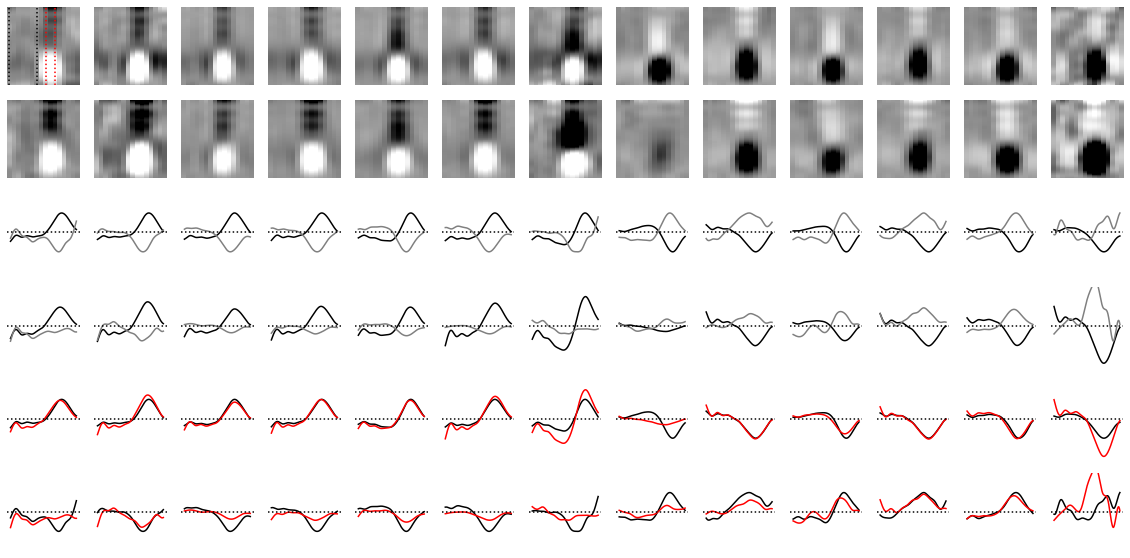

In [20]:
#plot the cluster averages and normalized temporal kernels and calculate latency and surround strength

polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]
latency = np.zeros(len(polarity))
surround_strength = np.zeros(len(polarity))

latency_drug = np.zeros(len(polarity))
surround_strength_drug = np.zeros(len(polarity))

center_change_index = np.zeros(len(polarity))
surround_change_index =  np.zeros(len(polarity))

maxmin = 0.06
plot_range = 2

fig, ax = plt.subplots(6, 13, figsize=(20, 10))
for i, clust in enumerate(ipl_depth_order):
    
#     ax[0, i].imshow(spline_array[quality_mask[0],:][s_df_xz_masked['new_cluster_assignment']==clust], aspect=12, cmap='Greys_r')
#     ax[0, i].set_yticklabels([])
#     ax[0, i].set_xticklabels([])
#     ax[0, i].axis('off')
    
    ax[0, i].imshow(average_filters[:,10:26,clust]/np.linalg.norm(average_filters[:,11:19,clust]), 
                    aspect='auto', cmap='Greys_r', vmin=-maxmin, vmax=maxmin)
    if i == 0:
        ax[0, i].axvline(10-10, color='k', linestyle='dotted')
        ax[0, i].axvline(16-10, color='k', linestyle='dotted')
        ax[0, i].axvline(18-10, color='r', linestyle='dotted')
        ax[0, i].axvline(20-10, color='r', linestyle='dotted')
    ax[0, i].axis('off')
    
    ax[1, i].imshow(average_filters_drug[:,10:26,clust]/np.linalg.norm(average_filters[:,11:19,clust]), 
                    aspect='auto', cmap='Greys_r', vmin=-maxmin, vmax=maxmin)
    
    ax[1, i].axis('off')

    
    
    avg_filter_flipped = average_filters[:,:,clust]*polarity[clust] #deal with off cells

    ax[2, i].plot(polarity[clust]*np.mean(avg_filter_flipped[:,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[50:,18:21], axis=1)), color='k',)
    ax[2, i].plot(polarity[clust]*np.mean(avg_filter_flipped[:,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[100:,10:17], axis=1))*-1, color='grey')
#     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
    ax[2, i].axhline(color='k', linestyle='dotted')
    ax[2, i].set_yticklabels([])
    ax[2, i].set_xticklabels([])
    ax[2, i].axis('off')
    ax[2, i].set_ylim([-plot_range,plot_range])
    
    
    avg_filter_flipped_drug = average_filters_drug[:,:,clust]*polarity[clust] #deal with off cells

    ax[3, i].plot(polarity[clust]*np.mean(avg_filter_flipped_drug[:,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[50:,18:21], axis=1)), color='k',)
    ax[3, i].plot(polarity[clust]*np.mean(avg_filter_flipped_drug[:,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[100:,10:17], axis=1))*-1, color='grey')
#     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
    ax[3, i].axhline(color='k', linestyle='dotted')
    ax[3, i].set_yticklabels([])
    ax[3, i].set_xticklabels([])
    ax[3, i].axis('off')
    ax[3, i].set_ylim([-plot_range,plot_range])
    
    
    ax[4, i].plot(polarity[clust]*np.mean(avg_filter_flipped[:,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[50:,18:21], axis=1)), color='k',)
    ax[4, i].plot(polarity[clust]*np.mean(avg_filter_flipped_drug[:,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[50:,18:21], axis=1)), color='r',)
#     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
    ax[4, i].axhline(color='k', linestyle='dotted')
    ax[4, i].set_yticklabels([])
    ax[4, i].set_xticklabels([])
    ax[4, i].axis('off')
    ax[4, i].set_ylim([-plot_range,plot_range])
    
    ax[5, i].plot(polarity[clust]*np.mean(avg_filter_flipped[:,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[100:,10:17], axis=1))*-1, color='k')
    ax[5, i].plot(polarity[clust]*np.mean(avg_filter_flipped_drug[:,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[100:,10:17], axis=1))*-1, color='r')
#     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
    ax[5, i].axhline(color='k', linestyle='dotted')
    ax[5, i].set_yticklabels([])
    ax[5, i].set_xticklabels([])
    ax[5, i].axis('off')
    ax[5, i].set_ylim([-plot_range,plot_range])
    
#     Figpath = 'Fig_temp/'
#     savename = Figpath+"Cluster_avgs_"+str(i)+".pdf"
#     plt.savefig(savename, transparent=True, bbox_inches='tight')

#     plt.show()
    center = np.mean(avg_filter_flipped[100:230,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[100:230,18:21], axis=1))
    surround = np.mean(avg_filter_flipped[100:230,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[100:230,10:17], axis=1))
    
    center_drug = np.mean(avg_filter_flipped_drug[100:230,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[100:230,18:21], axis=1))
    surround_drug = np.mean(avg_filter_flipped_drug[100:230,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[100:230,10:17], axis=1))
    
    latency[clust] = np.argmax(center)-np.argmax(surround) 
    surround_strength[clust] = np.amin(np.mean(avg_filter_flipped[50:230,10:17], axis=1))/np.amax(np.mean(avg_filter_flipped[50:230,18:21], axis=1))

    latency_drug[clust] = np.argmax(center_drug)-np.argmax(surround_drug) 
    surround_strength_drug[clust] = np.amin(np.mean(avg_filter_flipped_drug[50:230,10:17], axis=1))/np.amax(np.mean(avg_filter_flipped_drug[50:230,18:21], axis=1))

    center_change_index[clust] = (np.amax(center) - np.amax(center_drug))/np.amax(center)
    surround_change_index[clust] = (np.amax(surround) - np.amax(surround_drug))/np.amax(surround)
    
    
# Figpath = 'Fig_temp/'
# savename = Figpath+"Cluster_avgs_TPMPA.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()
    

In [21]:
from scipy.optimize import curve_fit

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

0 70.56516356832894
1 65.95169126157721
2 68.17243440699238
3 59.78108858951494
4 67.55673669414578
5 75.59954557326087
6 72.43077726097013
7 70.36255225723622
8 64.56380310123853
9 60.76876093827739
10 68.16004891206488
11 62.97122061997233
12 71.08080610896786


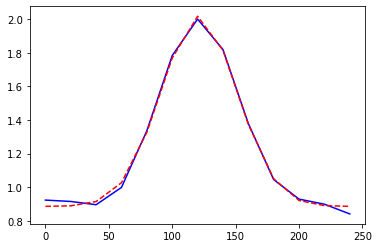

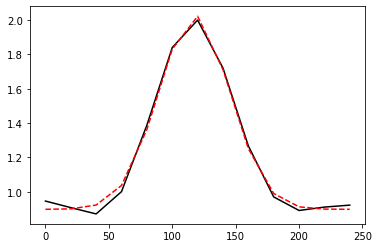

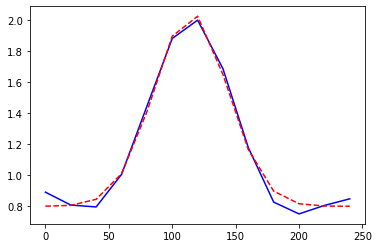

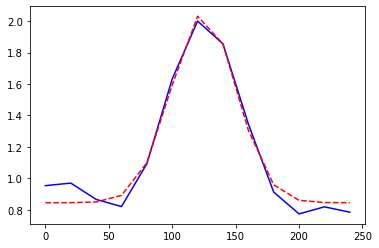

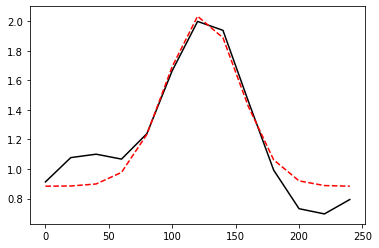

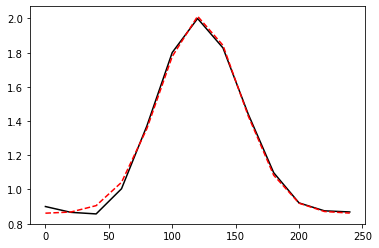

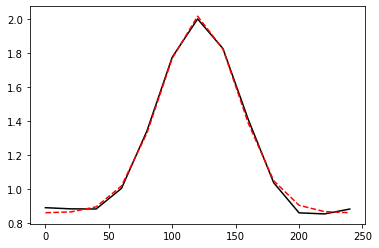

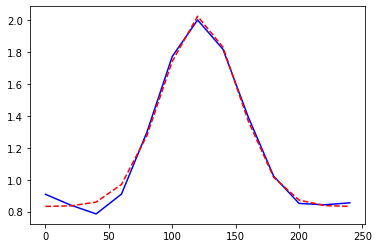

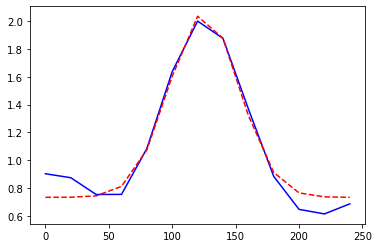

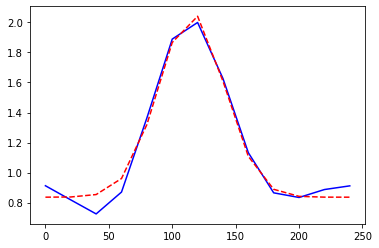

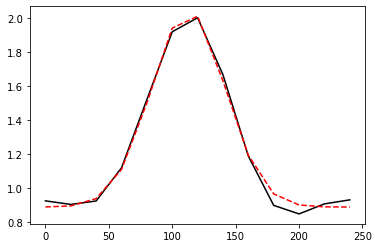

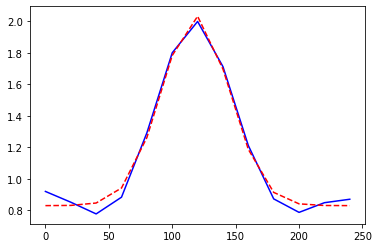

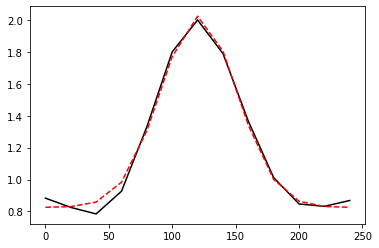

In [22]:
#calculate center FWHM by doing Gaussian Fit

center_fwhm=np.zeros(clusters.shape[0])
colors_polarity = ['black', 'red', 'blue']
for i in range(clusters.shape[0]):
    mean_filter = np.mean(average_filters[200:220,13:26,i], axis=0)*polarity[i]
    space_positions = np.arange(mean_filter.shape[0])*20 #in microns
    
    
    fig = plt.figure()
    plt.plot(space_positions, mean_filter/np.amax(mean_filter)+1, color=colors_polarity[polarity[i]+1])
    

    
    H, A, x0, sigma = gauss_fit(space_positions, mean_filter/np.amax(mean_filter)+1) #adding one to get the algorithm to behave
    FWHM = 2.35482 * sigma
    center_fwhm[i] = FWHM
    print(i, FWHM)
    plt.plot(space_positions, gauss(space_positions, *gauss_fit(space_positions, mean_filter/np.amax(mean_filter)+1)), '--r', label='fit')

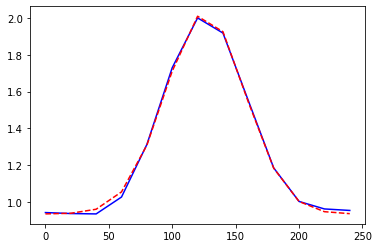

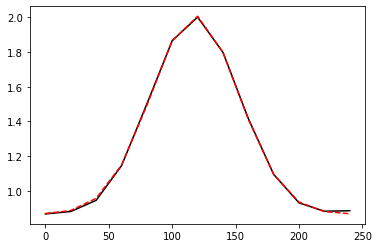

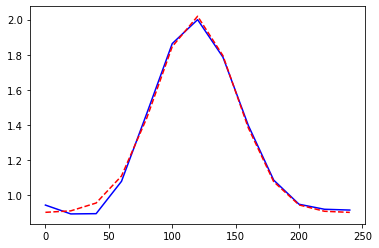

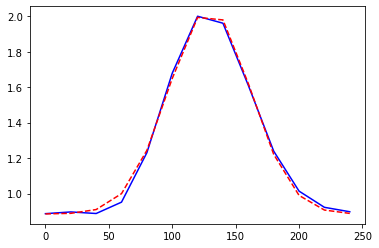

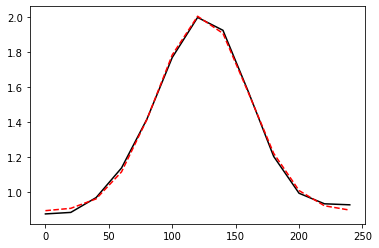

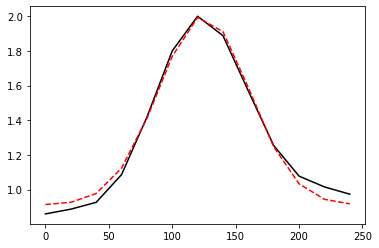

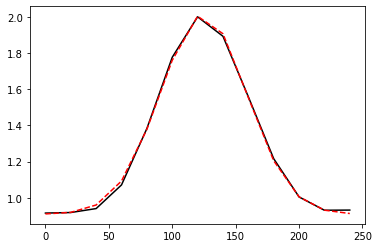

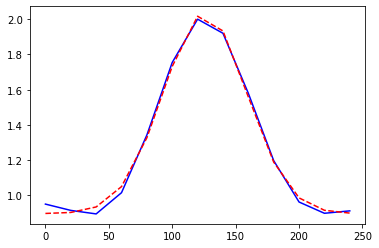

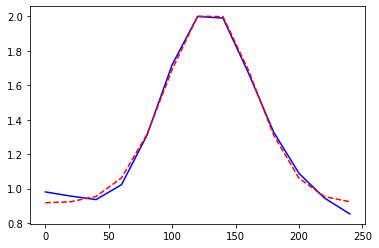

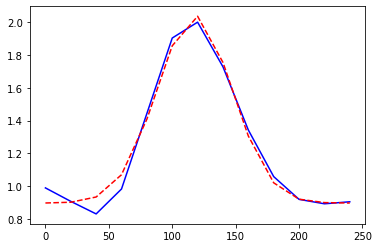

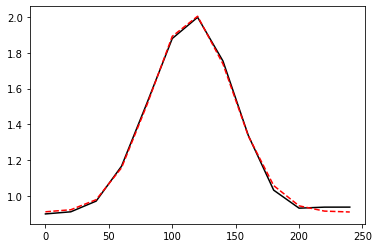

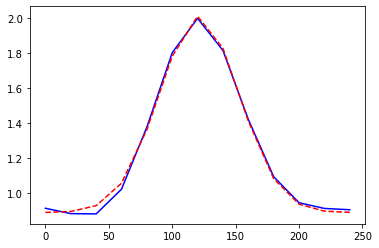

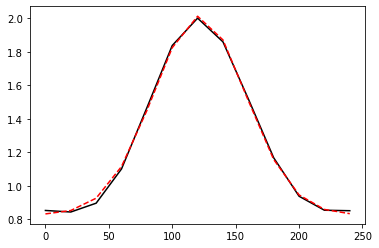

In [23]:
#calculate center FWHM by doing Gaussian Fit

center_fwhm_drug=np.zeros(clusters.shape[0])
colors_polarity = ['black', 'red', 'blue']
for i in range(clusters.shape[0]):
    mean_filter = np.mean(average_filters_drug[200:220,13:26,i], axis=0)*polarity[i] #correcting for stimulator delay
    space_positions = np.arange(mean_filter.shape[0])*20 #in microns
    
    
    fig = plt.figure()
    plt.plot(space_positions, mean_filter/np.amax(mean_filter)+1, color=colors_polarity[polarity[i]+1])
    

    
    H, A, x0, sigma = gauss_fit(space_positions, mean_filter/np.amax(mean_filter)+1) #adding one to get the algorithm to behave
    FWHM = 2.35482 * sigma
    center_fwhm_drug[i] = FWHM
    
    plt.plot(space_positions, gauss(space_positions, *gauss_fit(space_positions, mean_filter/np.amax(mean_filter)+1)), '--r', label='fit')

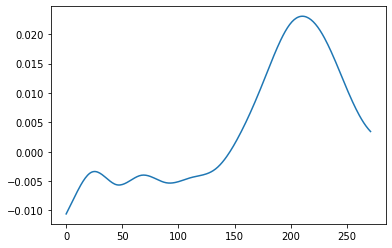

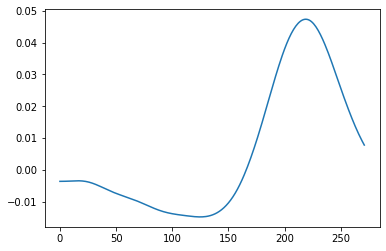

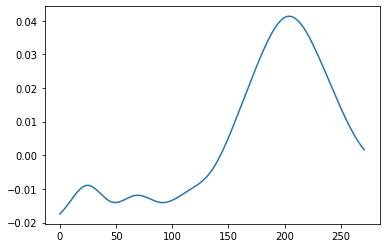

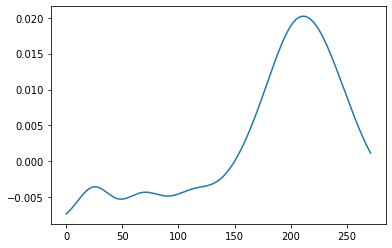

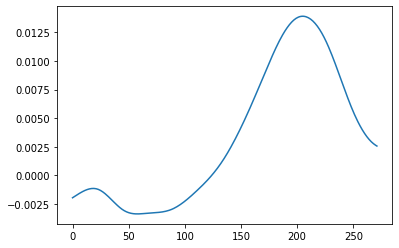

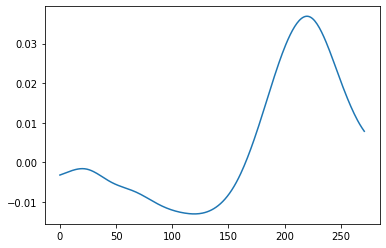

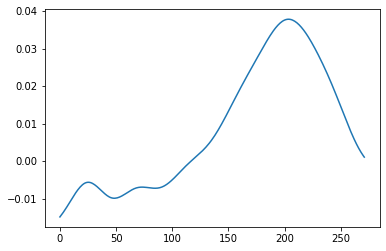

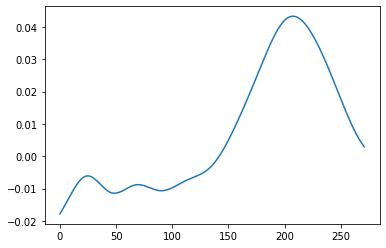

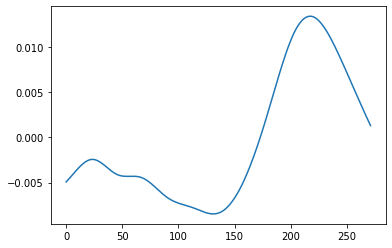

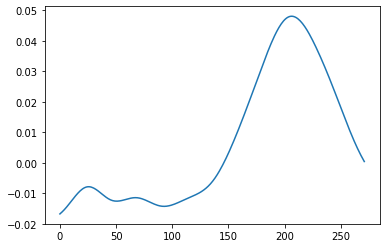

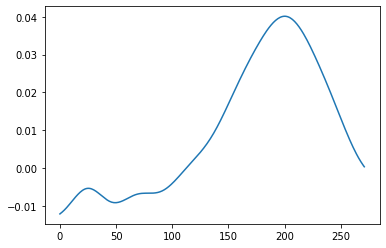

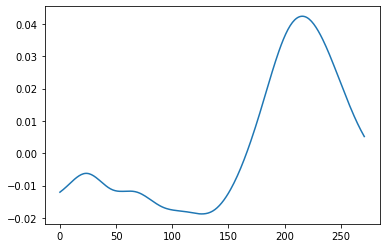

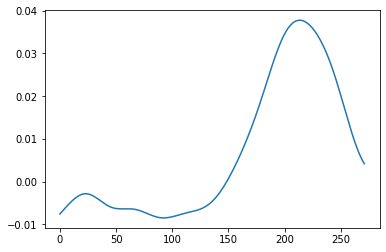

In [24]:
#calculate biphasic index

center_biphasic_index=np.zeros(clusters.shape[0])

for i in range(clusters.shape[0]):
    mean_filter = np.mean(average_filters[:,18:21,i], axis=1)*polarity[i]
    
    fig = plt.figure()
    plt.plot(mean_filter)
    
    filter_max = np.amax(mean_filter)
    filter_min = np.amin(mean_filter[50:200])
    biphasic_index = filter_min/filter_max*-1
    center_biphasic_index[i] = biphasic_index

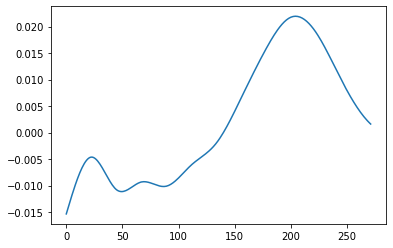

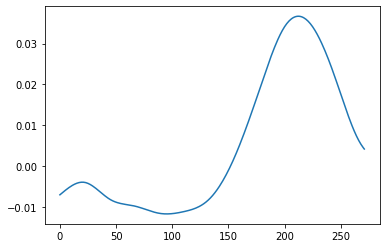

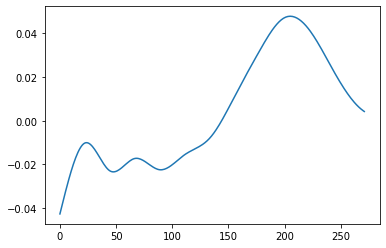

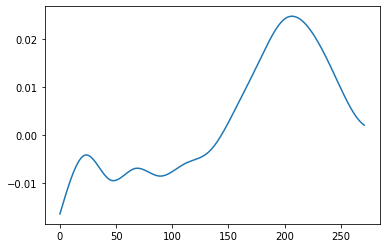

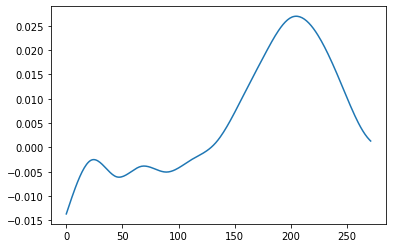

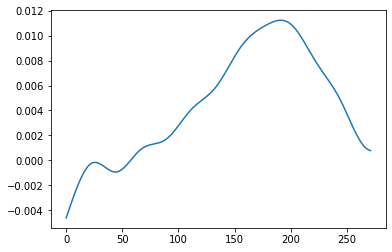

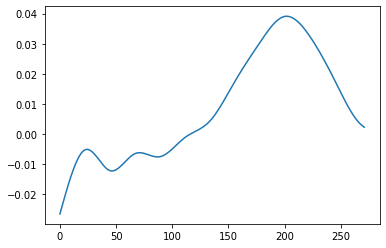

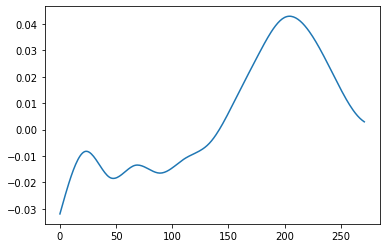

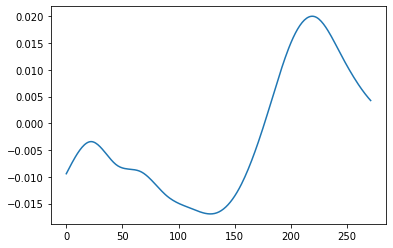

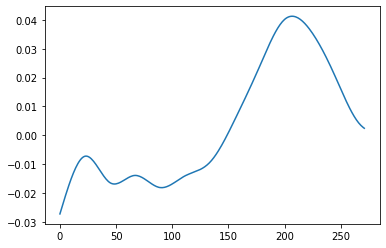

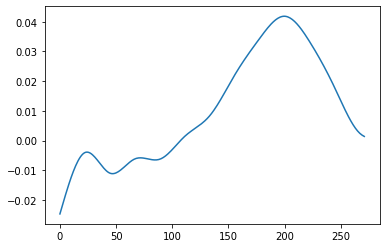

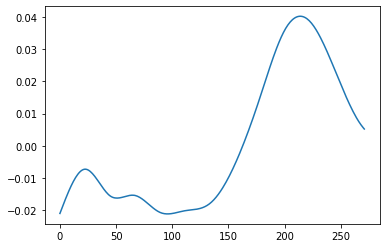

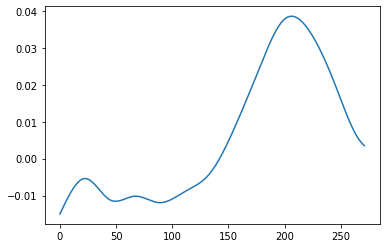

In [25]:
#calculate biphasic index

center_biphasic_index_drug=np.zeros(clusters.shape[0])

for i in range(clusters.shape[0]):
    mean_filter = np.mean(average_filters_drug[:,18:21,i], axis=1)*polarity[i]
    
    fig = plt.figure()
    plt.plot(mean_filter)
    
    filter_max = np.amax(mean_filter)
    filter_min = np.amin(mean_filter[50:200])
    biphasic_index = filter_min/filter_max*-1
    center_biphasic_index_drug[i] = biphasic_index

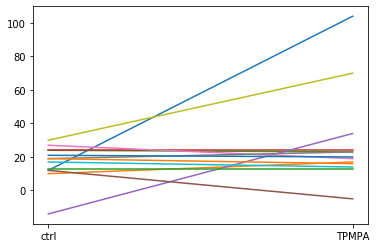

In [26]:
for i in range(13):
    plt.plot(['ctrl','TPMPA'], [latency[i], latency_drug[i]])

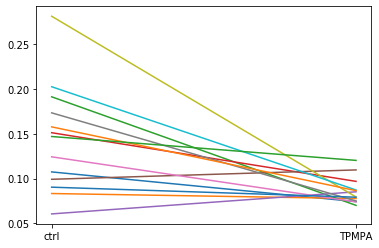

In [27]:
for i in range(13):
    plt.plot(['ctrl','TPMPA'], [surround_strength[i]*-1, surround_strength_drug[i]*-1])

(-0.15, 1.15)

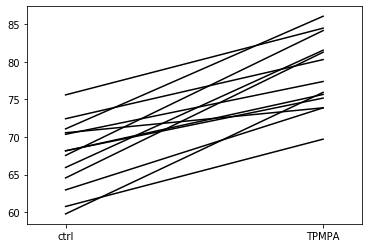

In [28]:
for i in range(13):
    plt.plot(['ctrl','TPMPA'], [abs(center_fwhm[i]), abs(center_fwhm_drug[i])], c='k')

axes=plt.gca()
axes.set_xlim([-.15,1.15])
    

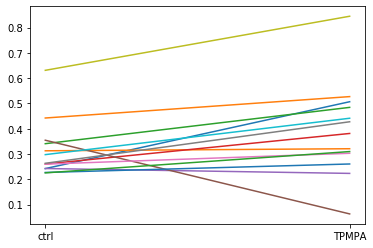

In [29]:
for i in range(13):
    plt.plot(['ctrl','TPMPA'], [center_biphasic_index[i], center_biphasic_index_drug[i]])

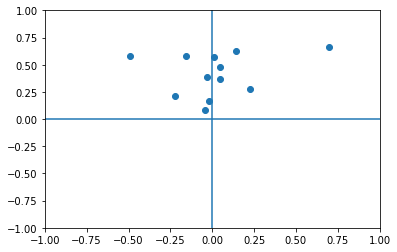

In [30]:
plt.scatter(center_change_index, surround_change_index)
axes = plt.gca()
axes.set_ylim([-1,1])
axes.set_xlim([-1,1])
axes.axhline(0)
axes.axvline(0)

# motion prediction model

In [31]:
def get_svg_parameters_on_screen(dendrite_length, moving_bar_length, stimulus_velocity,
                             starting_point, distance_covered, real_time_lag, time_points, space_per_pixel):
    temporal_conversion = time_points / real_time_lag  # From seconds to pixel.
    spatial_conversion = 1 / space_per_pixel  # From um to pixel.

    # Moving bar is already fully on screen at t = 0
    distance_moved = distance_covered - moving_bar_length  # [um]
    stimulation_time = (distance_moved / stimulus_velocity)  # [s]

    # Convert from seconds & um to pixel
    stimulation_time_pixel = stimulation_time * temporal_conversion

    distance_moved_pixel = distance_moved * spatial_conversion
    dendrite_length_pixel = dendrite_length * spatial_conversion
    moving_bar_length_pixel = moving_bar_length * spatial_conversion
    starting_point_pixel = starting_point * spatial_conversion
    distance_covered_pixel = distance_covered * spatial_conversion

    # Slope of diagonal
    slope = -stimulation_time_pixel / distance_moved_pixel

    # Calculate thickness of diagonal
    alpha = np.arctan(stimulation_time_pixel / distance_moved_pixel)
    diagonal_thickness = moving_bar_length_pixel * np.sin(alpha)

    # Calculate coordinates for beginning & end of diagonal
    # Diagonal starts and ends out of picture to allow for a smooth & exact picture.
    x_start = starting_point_pixel
    x_stop = x_start + distance_covered_pixel

    y_start = (moving_bar_length_pixel / 2) * slope  # Negative
    y_stop = stimulation_time_pixel - y_start

    return (stimulation_time_pixel, dendrite_length_pixel,
            diagonal_thickness,
            x_start, x_stop, y_start, y_stop)

In [32]:
#pull the convolution parameters for modeling
convolution_params = {}
file = h5py.File('Data/Fig5.hdf5', 'r')
dict_group_load = file['convolution_params']
dict_group_keys = dict_group_load.keys()
for k in dict_group_keys:
    convolution_params[k]= np.float(dict_group_load[k][0])
    
real_time_lag = convolution_params['real_time_lag']
time_points = convolution_params['time_points']
space_per_pixelx = convolution_params['space_per_pixelx']
space_per_pixely = convolution_params['space_per_pixely']
file.close()

array([-0.01466326, -0.02797254, -0.13906969, -0.1806051 , -0.00512839,
       -0.06125971, -0.12032074, -0.172969  , -0.60170076, -0.17488078,
       -0.05372297, -0.17191188, -0.14163288])

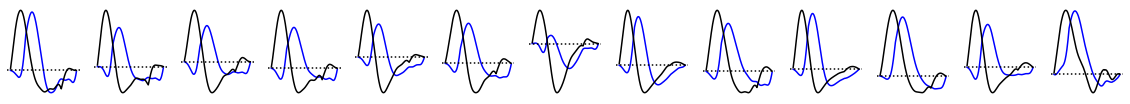

In [33]:
# Get response predictions for 1000 um/s for display

# get the stimulus for convolution

# convolution_stim_params_id = 'convolution_stim_params_id = 1'
# field = field1_c #field3

# convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
convolution_params['stimulus_velocity'] = 1000 # WARNING altering this to play around with velocity tuning
convolution_params['dendrite_length'] = 140
convolution_params['distance_covered'] = 140
# real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
# space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    space_per_pixel = space_per_pixelx
else:
    space_per_pixel = space_per_pixely

time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
    convolution_params['dendrite_length'],
    convolution_params['moving_bar_length'],
    convolution_params['stimulus_velocity'],
    convolution_params['starting_point'],
    convolution_params['distance_covered'],
    real_time_lag,
    time_points,
    space_per_pixel
)

string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
    <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
      <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
          stroke-width="{10}" stroke="white" stroke-linecap="square"/>
    </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

folder_str = 'Data/'
file_name = str(1)
name_svg = folder_str + file_name + ".svg"
name_png = folder_str + file_name + ".png"

new_file = open(name_svg, "wt")
new_file.write(string_svg)
new_file.close()

cairosvg.svg2png(url=name_svg, write_to=name_png)

stimulus_image = np.array(Image.open(name_png).convert('L'))



#get convolved responses

# cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
dsi = np.zeros(13)
dsi_off = np.zeros(13)

fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):
    # get the necessaries
    # spline = (NoiseSplineRF2 & key).fetch1('spl')
    spline = average_filters[:,:,clust]
    edge_buffer = 1 #changing to at least partially correct for the 
    # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
    stimulus_image_rev = np.flip(stimulus_image, axis=0)
    kernel_type = 'left'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
    # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

    # set up and crop the kernel
    kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

    # get the location of the RF center in the kernel
    spline_temp = spline[edge_buffer:-(edge_buffer+20), :] #correcting for time offset
    index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
    peak_y = index_max[1]
    peak_y = 19

    # crop the kernel depending on the type of experiment
    if kernel_type == 'right':
        spline_cut = spline[edge_buffer:-(edge_buffer+20), np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
    elif kernel_type == 'left':
        spline_cut = spline[edge_buffer:-(edge_buffer+20), np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
    elif kernel_type == 'full':
        spline_cut = spline[edge_buffer:-(edge_buffer+20),
                     0:kernel_length]  # should be full kernel, just adding space range just in case
    elif kernel_type == 'centered':
        spline_cut = spline[edge_buffer:-(edge_buffer+20),
                     np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
    else:
        spline_cut = spline  # just to make the code happy, this should never be the option
    # can code in other possibilities here...

    # check whether cut spline is big enough
    space_length = spline_cut.shape[1]
    if kernel_length == space_length:
        empty_flag = 0
        # setup output variables
        convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
        convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

        # loop through x positions and convolve
        for x_position in range(stimulus_image.shape[1]):
            ker = np.flip(spline_cut[:, x_position])
            img = stimulus_image[:, x_position]
            img2 = stimulus_image_rev[:, x_position]
            # and then convolve these two
            convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
            convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
    else:
        empty_flag = 1
        convolved_response = []
        convolved_response_rev = []

    response = np.sum(convolved_response, axis=1)
    response_rev = np.sum(convolved_response_rev, axis=1)
    max_response = np.amax(response[:300])
    max_response_rev = np.amax(response_rev[:300])
    max_response_off = np.amin(response[:300])
    max_response_rev_off = np.amin(response_rev[:300])
    dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
    dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#     print(dsi, dsi_off)
#     plt.figure()
    ax[i].plot(response*polarity[clust], color='b')
    ax[i].plot(response_rev*polarity[clust], color='k')
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Convolved_responses_1000um_s_control.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
dsi_all


array([-0.13082974, -0.02020284, -0.06743555, -0.09730903, -0.07796696,
        0.07133292, -0.06046377, -0.06279607, -0.10038888, -0.07246947,
       -0.03237376, -0.08558636, -0.01911625])

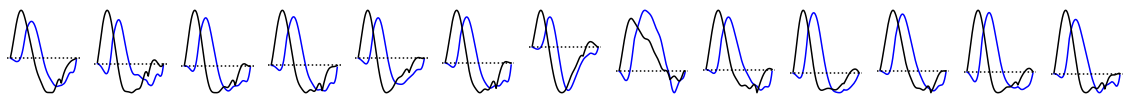

In [34]:
# Get response predictions for 1000 um/s for display drug

# get the stimulus for convolution

# convolution_stim_params_id = 'convolution_stim_params_id = 1'
# field = field1_c #field3

# convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
convolution_params['stimulus_velocity'] = 1000 # WARNING altering this to play around with velocity tuning
convolution_params['dendrite_length'] = 140
convolution_params['distance_covered'] = 140
# real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
# space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    space_per_pixel = space_per_pixelx
else:
    space_per_pixel = space_per_pixely

time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
    convolution_params['dendrite_length'],
    convolution_params['moving_bar_length'],
    convolution_params['stimulus_velocity'],
    convolution_params['starting_point'],
    convolution_params['distance_covered'],
    real_time_lag,
    time_points,
    space_per_pixel
)

string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
    <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
      <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
          stroke-width="{10}" stroke="white" stroke-linecap="square"/>
    </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

folder_str = 'Data/'
file_name = str(1)
name_svg = folder_str + file_name + ".svg"
name_png = folder_str + file_name + ".png"

new_file = open(name_svg, "wt")
new_file.write(string_svg)
new_file.close()

cairosvg.svg2png(url=name_svg, write_to=name_png)

stimulus_image = np.array(Image.open(name_png).convert('L'))



#get convolved responses

# cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
dsi = np.zeros(13)
dsi_off = np.zeros(13)

fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):
    # get the necessaries
    # spline = (NoiseSplineRF2 & key).fetch1('spl')
    spline = average_filters_drug[:,:,clust]
    edge_buffer = 1 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
    # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
    stimulus_image_rev = np.flip(stimulus_image, axis=0)
    kernel_type = 'left'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
    # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

    # set up and crop the kernel
    kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

    # get the location of the RF center in the kernel
    spline_temp = spline[edge_buffer:-(edge_buffer+20), :]
    index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
    peak_y = index_max[1]
    peak_y = 19

    # crop the kernel depending on the type of experiment
    if kernel_type == 'right':
        spline_cut = spline[edge_buffer:-(edge_buffer+20), np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
    elif kernel_type == 'left':
        spline_cut = spline[edge_buffer:-(edge_buffer+20), np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
    elif kernel_type == 'full':
        spline_cut = spline[edge_buffer:-(edge_buffer+20),
                     0:kernel_length]  # should be full kernel, just adding space range just in case
    elif kernel_type == 'centered':
        spline_cut = spline[edge_buffer:-(edge_buffer+20),
                     np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
    else:
        spline_cut = spline  # just to make the code happy, this should never be the option
    # can code in other possibilities here...

    # check whether cut spline is big enough
    space_length = spline_cut.shape[1]
    if kernel_length == space_length:
        empty_flag = 0
        # setup output variables
        convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
        convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

        # loop through x positions and convolve
        for x_position in range(stimulus_image.shape[1]):
            ker = np.flip(spline_cut[:, x_position])
            img = stimulus_image[:, x_position]
            img2 = stimulus_image_rev[:, x_position]
            # and then convolve these two
            convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
            convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
    else:
        empty_flag = 1
        convolved_response = []
        convolved_response_rev = []

    response = np.sum(convolved_response, axis=1)
    response_rev = np.sum(convolved_response_rev, axis=1)
    max_response = np.amax(response[:300])
    max_response_rev = np.amax(response_rev[:300])
    max_response_off = np.amin(response[:300])
    max_response_rev_off = np.amin(response_rev[:300])
    dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
    dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#     print(dsi, dsi_off)
#     plt.figure()
    ax[i].plot(response*polarity[clust], color='b')
    ax[i].plot(response_rev*polarity[clust], color='k')
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')


# Figpath = 'Fig_temp/'
# savename = Figpath+"Convolved_responses_1000um_s_TPMPA.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
dsi_all


In [35]:
dsi_control = np.array([-0.01466326, -0.02797254, -0.13906969, -0.1806051 , -0.00512839,
       -0.06125971, -0.12032074, -0.172969  , -0.60170076, -0.17488078,
       -0.05372297, -0.17191188, -0.14163288])*-1
dsi_drug = np.array([-0.13082974, -0.02020284, -0.06743555, -0.09730903, -0.07796696,
        0.07133292, -0.06046377, -0.06279607, -0.10038888, -0.07246947,
       -0.03237376, -0.08558636, -0.01911625])*-1

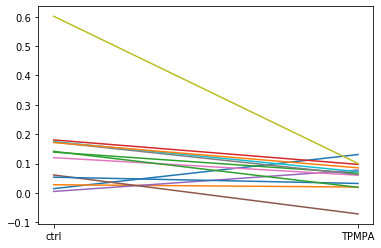

In [36]:
for i in range(13):
    plt.plot(['ctrl','TPMPA'], [dsi_control[i], dsi_drug[i]])

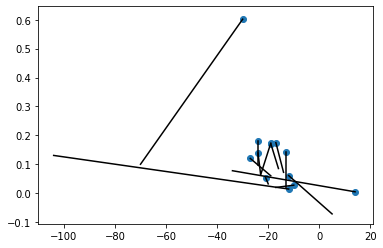

In [37]:
# ipl_depth_order_omit_flip = [ 0,  3,  9,  7, 11,  2,  8,  6,  1, 10, 12,  4]
for i in ipl_depth_order:
    plt.plot([latency[i]*-1, latency_drug[i]*-1], [dsi_control[i], dsi_drug[i]], color='k')
    
plt.scatter(latency*-1, dsi_control)


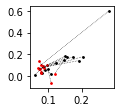

In [39]:
#FOR FIGURE
fig = plt.figure(figsize=(1.5,1.5))

#this is the one
for i in ipl_depth_order:
    plt.plot([surround_strength[i]*-1, surround_strength_drug[i]*-1], [dsi_control[i], dsi_drug[i]], color='k',linewidth=.6,linestyle='dotted')
    
plt.scatter(surround_strength*-1, dsi_control,s=3,c='k')
plt.scatter(surround_strength_drug*-1, dsi_drug,s=3,c='r')
# plt.scatter(surround_strength_drug*-1, dsi_drug)

axes=plt.gca()

plt.show()

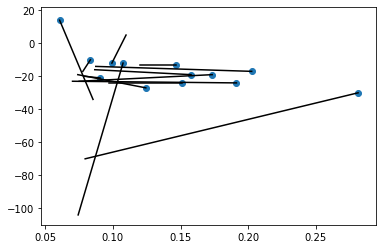

In [41]:

for i in ipl_depth_order:
    plt.plot([surround_strength[i]*-1, surround_strength_drug[i]*-1], [latency[i]*-1, latency_drug[i]*-1], color='k')
    
plt.scatter(surround_strength*-1, latency*-1)


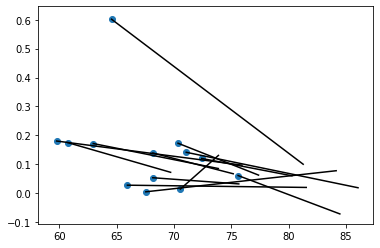

In [42]:

for i in ipl_depth_order:
    plt.plot([abs(center_fwhm[i]), center_fwhm_drug[i]], [dsi_control[i], dsi_drug[i]], color='k')
    
plt.scatter(abs(center_fwhm), dsi_control)


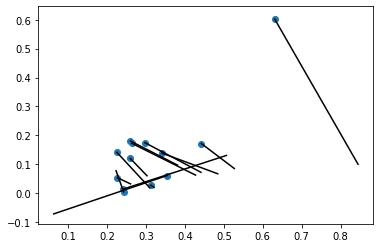

In [43]:

for i in ipl_depth_order:
    plt.plot([center_biphasic_index[i], center_biphasic_index_drug[i]], [dsi_control[i], dsi_drug[i]], color='k')
    
plt.scatter(center_biphasic_index, dsi_control)


In [47]:
def convolved_dsis(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution

#     convolution_stim_params_id = 'convolution_stim_params_id = 1'
#     field = field3

#     convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 140
    convolution_params['distance_covered'] = 140
#     real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
#     space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

#     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)

    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters[:,:,clust] #average_filters_mirror[:, :, clust] 4:24
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'left'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
#         print(peak_y)
        peak_y = 19

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
    #     ax[i].set_yticklabels([])
    #     ax[i].set_xticklabels([])
    #     ax[i].axis('off')

    # Figpath = 'Fig_temp/'
    # savename = Figpath+"Convolved_responses.pdf"
    # plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

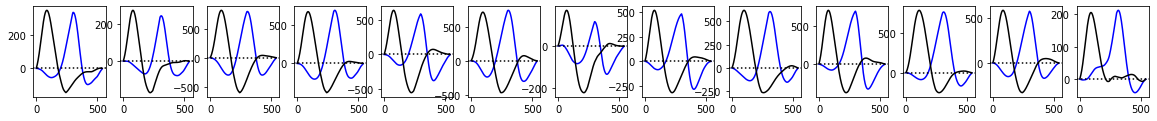

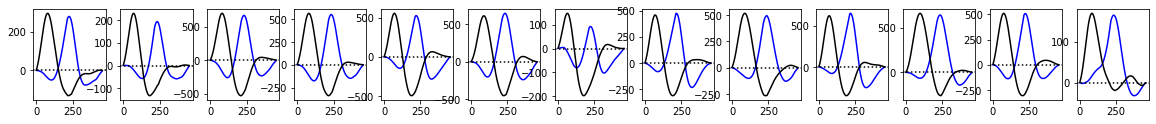

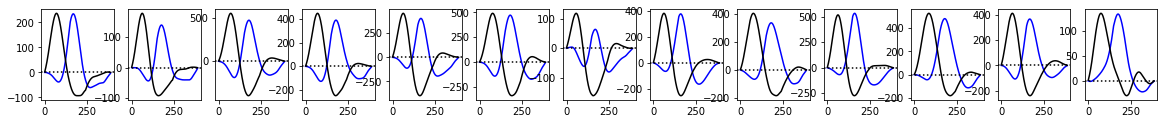

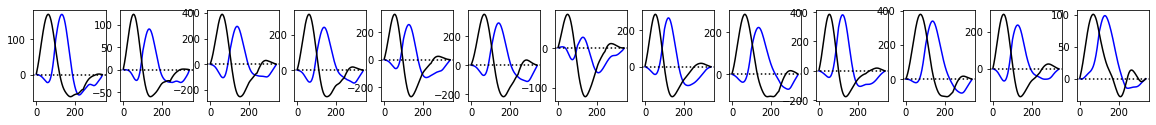

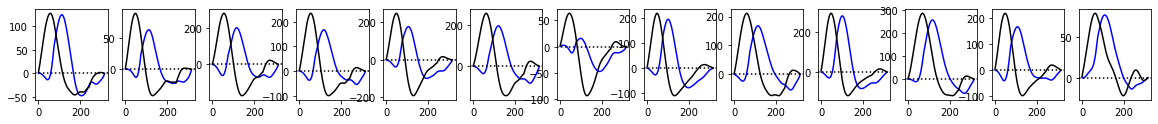

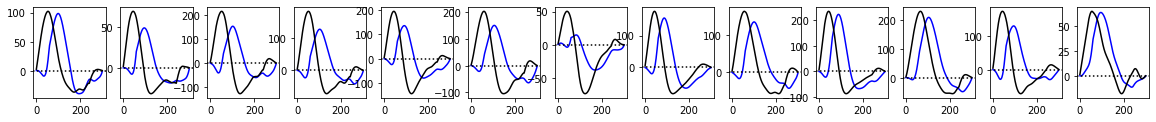

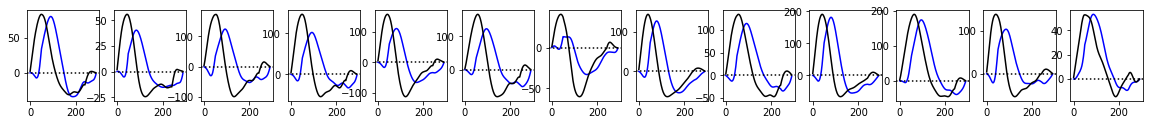

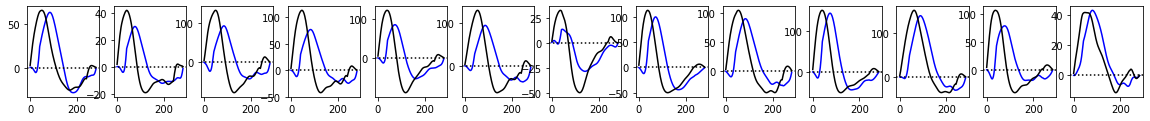

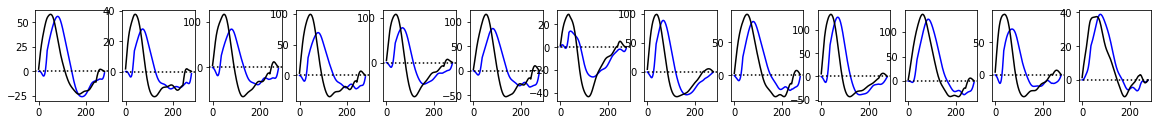

In [48]:
#run models
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis(velocity, convolution_params)
    dsi_all_all[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

In [49]:
def convolved_dsis_centered(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution

#     convolution_stim_params_id = 'convolution_stim_params_id = 1'
#     field = field3

#     convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 260
    convolution_params['distance_covered'] = 260
#     real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
#     space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

#     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)

    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters[:,13:26,clust]
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'full'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
        peak_y = 19

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
#             spline_cut = spline[edge_buffer:-edge_buffer,
#                          4:11]
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(peak_y - (kernel_length-1) / 2):np.int(peak_y + (kernel_length-1) / 2 +1)]
#             print(kernel_length)
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
        ax[i].axis('off')
#         if velocity == 1000:
#             Figpath = 'Fig_temp/'
#             savename = Figpath+"Convolved_responses_1000.pdf"
#             plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

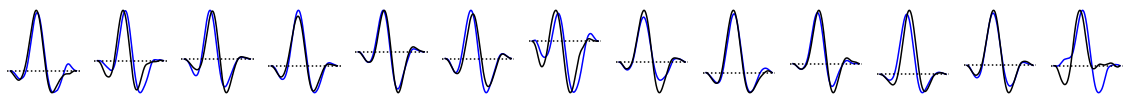

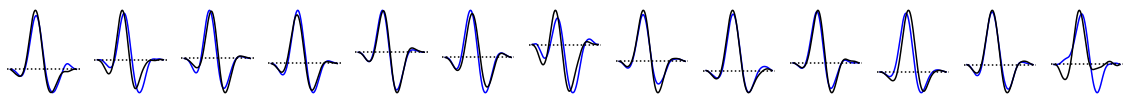

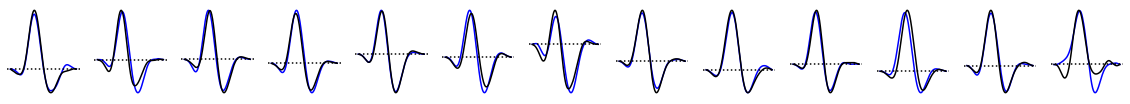

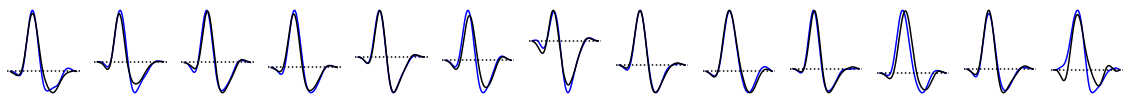

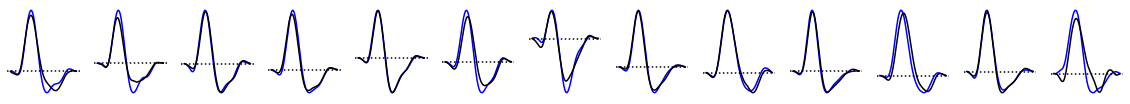

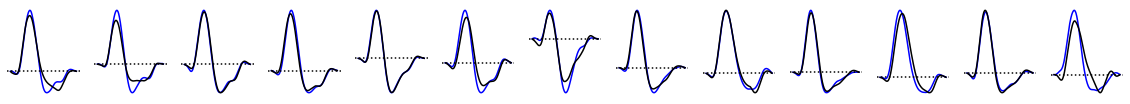

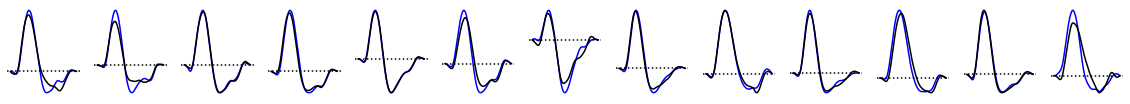

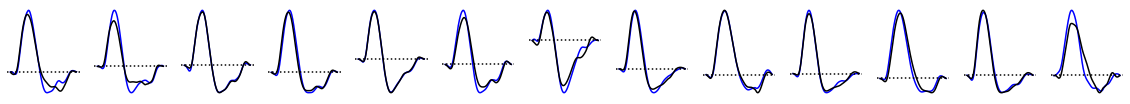

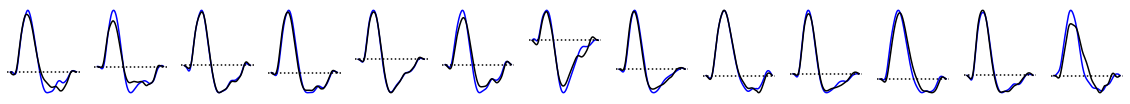

In [50]:
# run models
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all_centered = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis_centered(velocity, convolution_params)
    dsi_all_all_centered[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

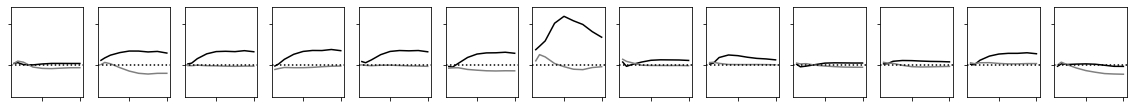

In [51]:
#DSI as a function of velocity for each stimulus case
fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):

    ax[i].plot(velocities, dsi_all_all[:, clust]*-1, color='k')
    ax[i].plot(velocities, dsi_all_all_centered[:, clust]*-1, color='grey')
    ax[i].set_ylim([-.4, .72])
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
#     ax[i].axis('off')
# plt.legend()

plt.show()

In [52]:
def convolved_dsis_drug(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution

#     convolution_stim_params_id = 'convolution_stim_params_id = 1'
#     field = field3

#     convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 140
    convolution_params['distance_covered'] = 140
#     real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
#     space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

#     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)

    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters_drug[:,:,clust] #average_filters_mirror[:, :, clust] 4:24
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'left'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
#         print(peak_y)
        peak_y = 19

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
    #     ax[i].set_yticklabels([])
    #     ax[i].set_xticklabels([])
    #     ax[i].axis('off')

    # Figpath = 'Fig_temp/'
    # savename = Figpath+"Convolved_responses.pdf"
    # plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

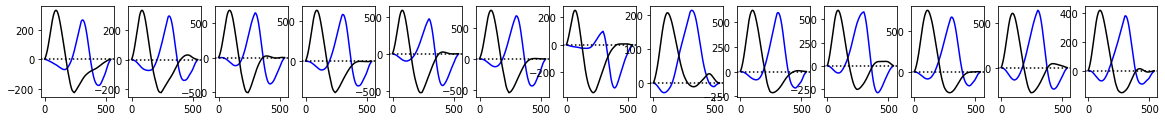

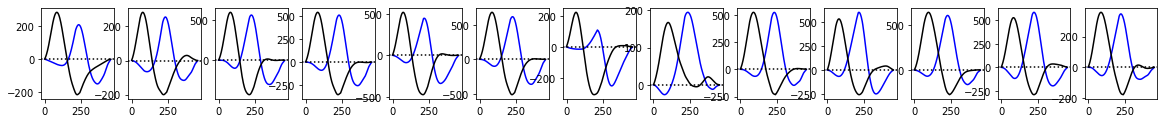

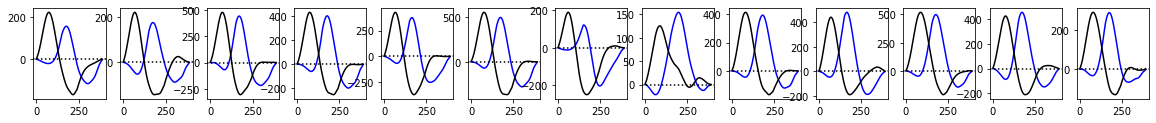

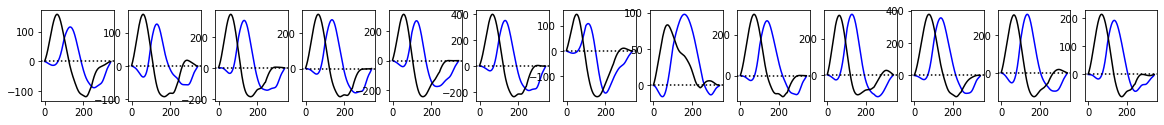

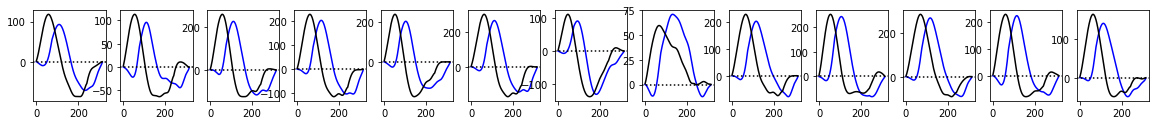

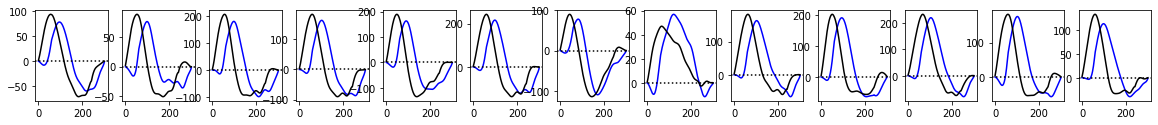

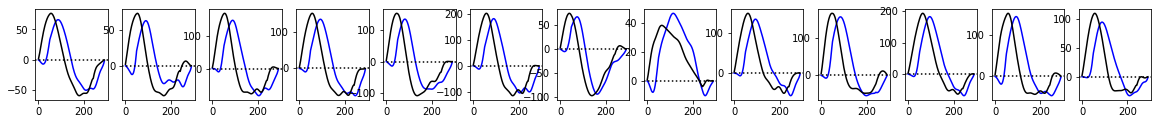

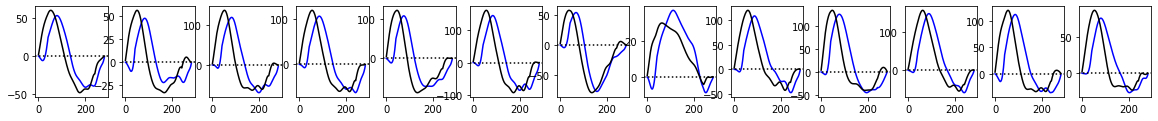

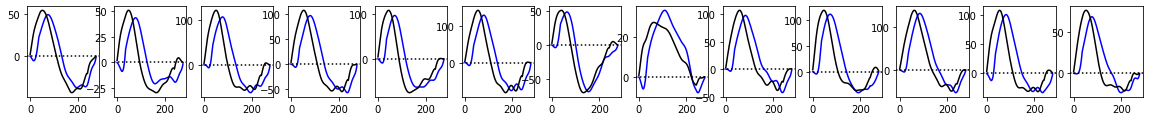

In [53]:
#run models
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all_drug = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis_drug(velocity, convolution_params)
    dsi_all_all_drug[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

In [54]:
def convolved_dsis_centered_drug(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution

#     convolution_stim_params_id = 'convolution_stim_params_id = 1'
#     field = field3

#     convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 260
    convolution_params['distance_covered'] = 260
#     real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
#     space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

#     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)

    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters_drug[:,13:26,clust]
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'full'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
        peak_y = 19

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
#             spline_cut = spline[edge_buffer:-edge_buffer,
#                          4:11]
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(peak_y - (kernel_length-1) / 2):np.int(peak_y + (kernel_length-1) / 2 +1)]
#             print(kernel_length)
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
        ax[i].axis('off')
#         if velocity == 1000:
#             Figpath = 'Fig_temp/'
#             savename = Figpath+"Convolved_responses_1000.pdf"
#             plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

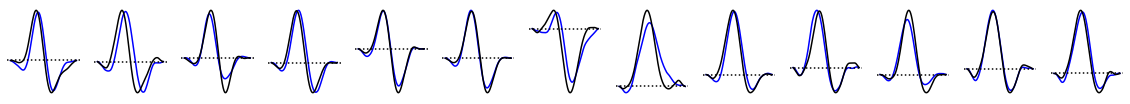

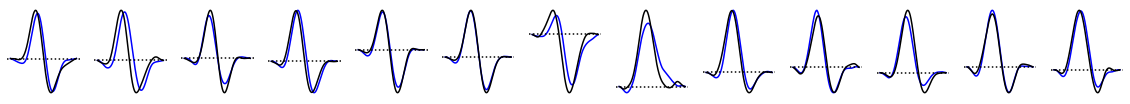

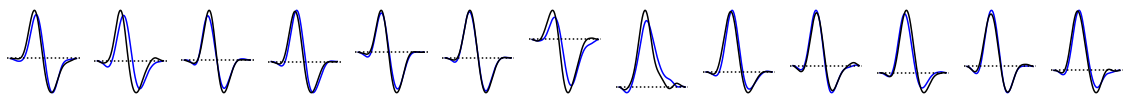

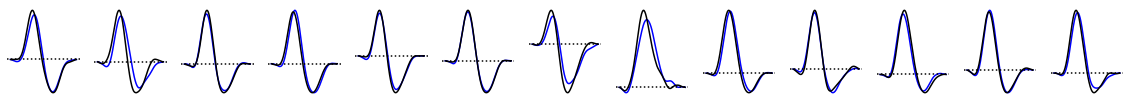

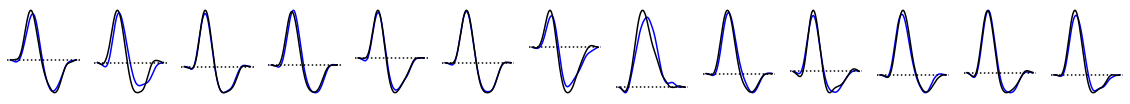

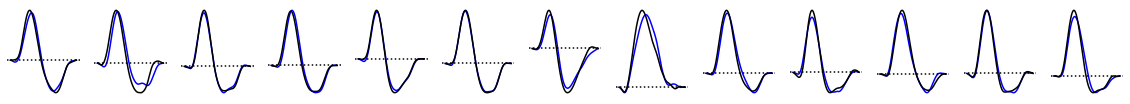

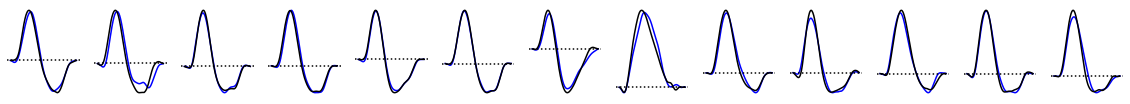

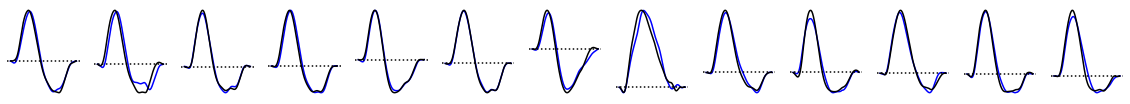

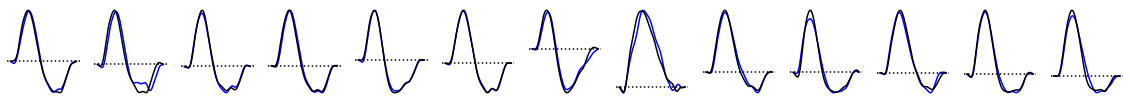

In [55]:
# run models
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all_centered_drug = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis_centered_drug(velocity, convolution_params)
    dsi_all_all_centered_drug[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

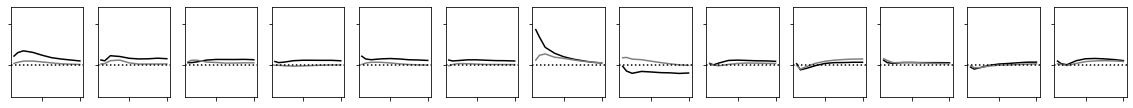

In [56]:
#DSI as a function of velocity for each stimulus case
fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):

    ax[i].plot(velocities, dsi_all_all_drug[:, clust]*-1, color='k')
    ax[i].plot(velocities, dsi_all_all_centered_drug[:, clust]*-1, color='grey')
    ax[i].set_ylim([-.4, .72])
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
#     ax[i].axis('off')
# plt.legend()

plt.show()

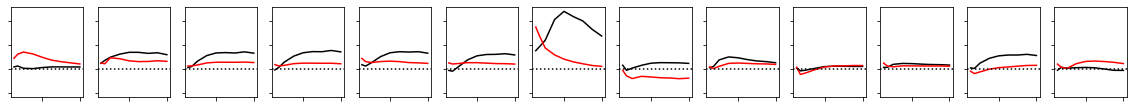

In [57]:
#DSI as a function of velocity for each stimulus case
fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):

    ax[i].plot(velocities, dsi_all_all[:, clust]*-1, color='k')
    ax[i].plot(velocities, dsi_all_all_drug[:, clust]*-1, color='r')
    ax[i].set_ylim([-.3, .65])
    ax[i].axhline(color='k', linestyle='dotted')
#     ax[i].axvline(x=500,color='k',linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
#     ax[i].axis('off')
# plt.legend()

plt.show()

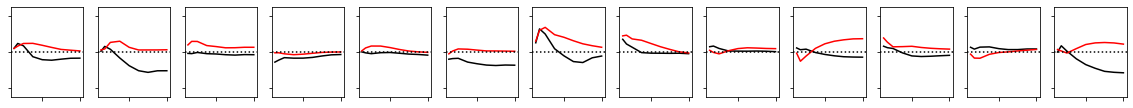

In [58]:
#DSI as a function of velocity for each stimulus case
fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):

    ax[i].plot(velocities, dsi_all_all_centered[:, clust]*-1, color='k')
    ax[i].plot(velocities, dsi_all_all_centered_drug[:, clust]*-1, color='r')
    ax[i].set_ylim([-.25, .25])
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
#     ax[i].axis('off')
# plt.legend()

plt.show()

# Motion responses by cluster

In [60]:
#pull these from hdf5
dsi_results_22 = pd.read_hdf('Data/Fig5.hdf5', 'dsi_results_22')
dsi_results_44 = pd.read_hdf('Data/Fig5.hdf5', 'dsi_results_44')
dsi_results_55 = pd.read_hdf('Data/Fig5.hdf5', 'dsi_results_55')

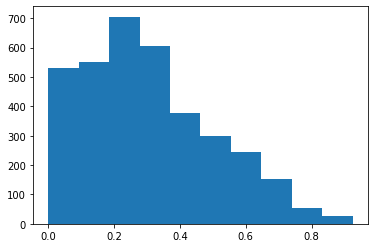

In [61]:
#plot distribution of stds
dsi_results_all = pd.concat([dsi_results_22, dsi_results_44, dsi_results_55])#dsi_results_55])#, dsi_results_22, 

plt.hist(dsi_results_all['mu_std_max'])

plt.show()

#remove non-responsive pixels, where the model failed to detect a large change in response
threshold = 0.1
dsi_results_all = dsi_results_all[dsi_results_all['mu_std_max']>threshold]
dsi_results_all.pop('mu_std_max')

std_100 = dsi_results_all['dsi_100'].std()
std_150 = dsi_results_all['dsi_150'].std()
std_200 = dsi_results_all['dsi_200'].std()
std_300 = dsi_results_all['dsi_300'].std()
std_100d = dsi_results_all['dsi_100d'].std()
std_150d = dsi_results_all['dsi_150d'].std()
std_200d = dsi_results_all['dsi_200d'].std()
std_300d = dsi_results_all['dsi_300d'].std()

mean_dsi = dsi_results_all['d_prime'].mean()
dsi_results_all['dsi_diff'] = dsi_results_all['dsi_100d']*-1 - dsi_results_all['dsi_100']*-1


# mean_dsi_d = dsi_results['d_prime'].mean()

std_dsi = np.array([std_100, std_150, std_200, std_300])
std_dsi_d = np.array([std_100d, std_150d, std_200d, std_300d])

std_top = mean_dsi + std_dsi
std_bottom = mean_dsi - std_dsi

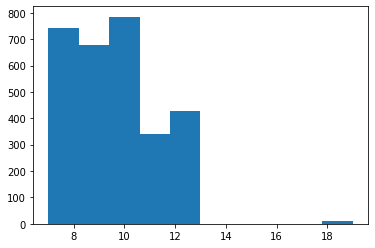

In [62]:
plt.hist(dsi_results_all['cluster_center'])
plt.show()

In [63]:
for_boxplot = pd.melt(dsi_results_all[dsi_results_all['cluster_center'].isin(
    [9,10,])].reset_index(), id_vars=['index', 'cluster_assignment', 'field'], 
                      value_vars=['dsi_100', 'dsi_100d'])

# for_stats["id"] = for_stats['index']+for_stats["field"]*10000

In [64]:
for_boxplot['value']=for_boxplot['value']*-1

In [65]:
ipl_depth_order_on = [0,  3,  9,  7, 11,  2,  8]#,  5]

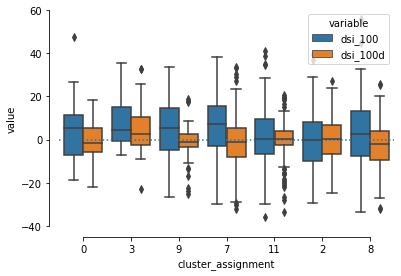

In [66]:
sns.boxplot(x="cluster_assignment", y="value", hue="variable", order=ipl_depth_order_on,
            data=for_boxplot)
sns.despine(offset=10, trim=True)

axes = plt.gca()

axes.axhline(linestyle='dotted')


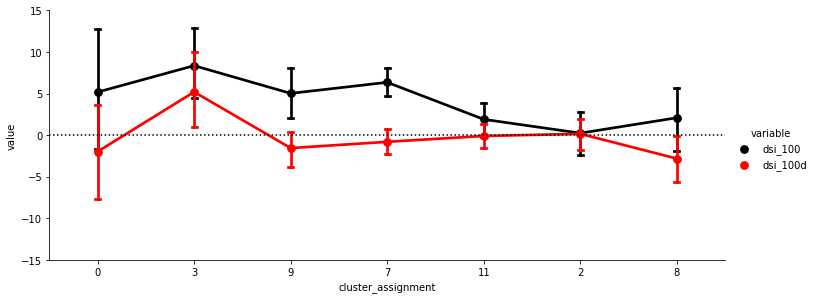

In [67]:
# fig = plt.figure(figsize=(10,5))
sns.catplot(x="cluster_assignment", y="value", hue="variable",order=ipl_depth_order_on, data=for_boxplot,
                capsize=.05, palette=['k','red'],  markersize=2,linewidth=1,height=4, aspect=10/4,
                kind="point", ci=95,
               
               )

axes = plt.gca()

axes.axhline(linestyle='dotted', color='k')
axes.set_ylim([-15,15])



# Figpath = 'Fig_temp/'
# savename = Figpath+"Motion_responses_control_TPMPA_CI95.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

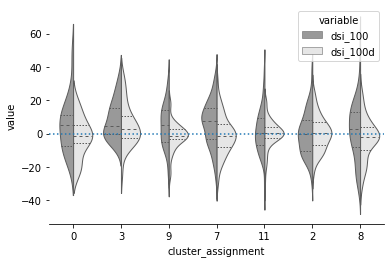

In [68]:
sns.violinplot(data=for_boxplot, x="cluster_assignment", y="value", hue="variable",order=ipl_depth_order_on,
               split=True, inner="quart", linewidth=1,
               palette={"dsi_100": "0.6", "dsi_100d": ".9"})
sns.despine(left=True)

axes = plt.gca()

axes.axhline(linestyle='dotted')

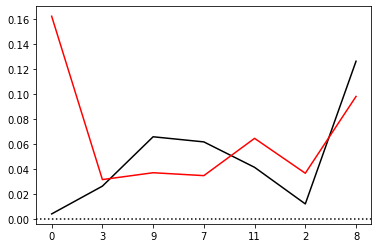

In [69]:
#plot predicted tuning for the 
x_label = [str(x) for x in ipl_depth_order_on]
dsi_500 = np.array([-0.00388651, -0.00481582, -0.0118834 , -0.02609174, -0.01328933,
       -0.02357507, -0.06204555, -0.0614782 , -0.12598572, -0.06557512,
       -0.03669119, -0.0411359 , -0.08708614])*-1


dsi_500d = np.array([-0.16195809, -0.02191479, -0.03642368, -0.03133512, -0.06679055,
        0.04030219, -0.01514642, -0.03450347, -0.09783039, -0.03681904,
       -0.04064258, -0.0643132 , -0.02733629])*-1

plt.plot(x_label, dsi_500[ipl_depth_order_on], c='k')
plt.plot(x_label, dsi_500d[ipl_depth_order_on], c='r')

axes=plt.gca()
axes.axhline(linestyle='dotted', color='k')

In [70]:
# stats: 2-way repeated measures Anova
import pingouin as pg
#need to remove the off clusters for testing
for_stats = for_boxplot[for_boxplot['cluster_assignment'].isin(ipl_depth_order_on)]
for_stats["id"] = for_stats['index']+for_stats["field"]*10000
pg.rm_anova(dv='value',
                  within=['cluster_assignment', 'variable'],
                  subject='id', data=for_stats, correction=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/gpfs01/euler/User/avlasits/.local/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/gpfs01/euler/User/avlasits/.local/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/gpfs01/euler/User/avlasits/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:380

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cluster_assignment,47124.854009,6,4110,7854.142335,-44.253805,1.000000e+00,NaN,-0.069066,NaN
1,variable,47228.028760,1,685,47228.028760,44.263855,5.876008e-11,5.876008e-11,0.060697,1.0
2,cluster_assignment * variable,15877.095909,6,4110,2646.182652,-15.927792,1.000000e+00,NaN,-0.023806,NaN


In [71]:
# pg.pairwise_ttests(dv='value', within='cluster_assignment', subject='id',
#                               between='variable', padjust='bonf', data=for_stats).round(4)


pg.pairwise_ttests(dv='value', within='variable', subject='id',
                              between='cluster_assignment', padjust='bonf', data=for_stats, within_first=False).round(10)#.tail(50)

,Contrast,cluster_assignment,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,cluster_assignment,-,8,2,False,True,-0.393507,153.257407,two-sided,6.944919e-01,1.000000e+00,bonf,0.173,-0.059506
1,cluster_assignment,-,8,11,False,True,-0.962308,126.393983,two-sided,3.377325e-01,1.000000e+00,bonf,0.231,-0.144635
2,cluster_assignment,-,8,0,False,True,-0.723474,25.196636,two-sided,4.760523e-01,1.000000e+00,bonf,0.329,-0.186607
3,cluster_assignment,-,8,7,False,True,-2.379344,129.685219,two-sided,1.880087e-02,3.948182e-01,bonf,2.017,-0.317711
4,cluster_assignment,-,8,3,False,True,-3.382404,55.819067,two-sided,1.318897e-03,2.769683e-02,bonf,29.677,-0.692087
5,cluster_assignment,-,8,9,False,True,-1.415936,139.782881,two-sided,1.590186e-01,1.000000e+00,bonf,0.452,-0.226795
6,cluster_assignment,-,2,11,False,True,-0.671922,204.036167,two-sided,5.023932e-01,1.000000e+00,bonf,0.172,-0.086910
7,cluster_assignment,-,2,0,False,True,-0.539586,21.184456,two-sided,5.951091e-01,1.000000e+00,bonf,0.294,-0.156939
8,cluster_assignment,-,2,7,False,True,-2.454461,219.525988,two-sided,1.488771e-02,3.126419e-01,bonf,2.248,-0.275183
9,cluster_assignment,-,2,3,False,True,-3.366320,43.092797,two-sided,1.611184e-03,3.383486e-02,bonf,29.338,-0.740558


In [72]:
diff_boxplot = pd.melt(dsi_results_all[dsi_results_all['cluster_center'].isin(
    [9,10])].reset_index(), id_vars=['index', 'cluster_assignment', 'field'], 
                      value_vars=['dsi_diff'])

In [73]:
diff_boxplot.shape

(1464, 5)

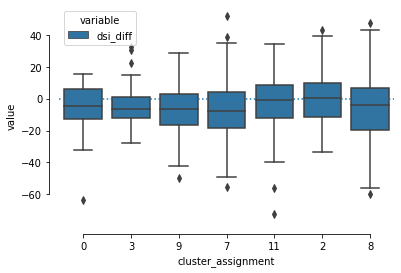

In [74]:
sns.boxplot(x="cluster_assignment", y="value", hue="variable", order=ipl_depth_order_on,
            data=diff_boxplot)
sns.despine(offset=10, trim=True)

axes = plt.gca()

axes.axhline(linestyle='dotted')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Motion_responses_control_TPMPA_diff.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

In [75]:
for_stats_diff = diff_boxplot[diff_boxplot['cluster_assignment'].isin(ipl_depth_order_on)]


pg.anova(dv='value',
                  between=['cluster_assignment'],
                  data=for_stats_diff)

,Source,ddof1,ddof2,F,p-unc,np2
0,cluster_assignment,6,679,2.846064,0.009602,0.024532


In [76]:
pg.pairwise_ttests(dv='value', between='cluster_assignment', data=for_stats_diff).round(3)

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,cluster_assignment,8,2,False,True,-1.657,144.107,two-sided,0.100,0.574,-0.253
1,cluster_assignment,8,11,False,True,-1.053,128.625,two-sided,0.294,0.252,-0.157
2,cluster_assignment,8,0,False,True,0.431,27.311,two-sided,0.670,0.286,0.104
3,cluster_assignment,8,7,False,True,0.840,114.998,two-sided,0.403,0.197,0.122
4,cluster_assignment,8,3,False,True,-0.488,78.621,two-sided,0.627,0.248,-0.086
5,cluster_assignment,8,9,False,True,0.529,140.586,two-sided,0.597,0.206,0.085
6,cluster_assignment,2,11,False,True,0.919,221.261,two-sided,0.359,0.207,0.116
7,cluster_assignment,2,0,False,True,1.450,21.349,two-sided,0.162,0.627,0.416
8,cluster_assignment,2,7,False,True,3.619,203.584,two-sided,0.000,61.236,0.419
9,cluster_assignment,2,3,False,True,0.997,52.607,two-sided,0.323,0.337,0.191


# Looking at example/average responses by cluster

In [77]:
cluster_num = 9 #9
cluster_frame = dsi_results_all[dsi_results_all['cluster_assignment']==cluster_num]
cluster_frame = cluster_frame[cluster_frame['field']==44]

In [78]:
cluster_frame

,d_prime,condition1,condition2,mu1,mu2,x_predict,mu,sig,x_predict_drug,mu_drug,...,dsi_150d,dsi_200d,dsi_300d,out_motion_d,in_motion_d,motion_origin_pref_d,cluster_assignment,cluster_center,field,dsi_diff
361,"[5.4989183229970955, -5.5658537950133855, 19.0...","[[0.0, 1.0, 100.0], [0.0, 1.0, 150.0], [0.0, 1...","[[1.2246467991473532e-16, -1.0, 100.0], [1.224...","[0.2731093407942806, 1.2346477220453913, 1.548...","[0.18770917735854661, 1.3210467429824397, 1.25...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.04245804333165615, -0.06430695703588774, ...","[[0.02236529875189669, 0.01574087641686328, 0....","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.1865458703754359, -0.19317778322881946, -...",...,2.819610,22.640880,15.388828,0.129032,0.139283,-0.038206,9,8.0,44.0,4.647382
393,"[-10.958884185406854, -0.8555411010350612, 3.6...","[[0.0, 1.0, 100.0], [0.0, 1.0, 150.0], [0.0, 1...","[[1.2246467991473532e-16, -1.0, 100.0], [1.224...","[0.11778698562987536, 0.8266897290924624, 0.86...","[0.2606972260727663, 0.8378419618202562, 0.816...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.019197329011356838, -0.009721602597100053...","[[0.017811520579128194, 0.013633121176758987, ...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[0.02302639921184469, 0.02096523690143339, 0....",...,-5.443623,10.251614,3.252428,0.074423,0.033881,0.374339,9,8.0,44.0,-4.829090
394,"[-1.2860127771208822, -13.435863293463383, 19....","[[0.0, 1.0, 100.0], [0.0, 1.0, 150.0], [0.0, 1...","[[1.2246467991473532e-16, -1.0, 100.0], [1.224...","[0.19642427784241098, 1.2249217887736314, 1.36...","[0.21702525865145333, 1.4351689221618795, 1.05...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[0.04018993197612619, 0.007972855303672331, -...","[[0.022588560373570807, 0.01588988303313031, 0...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.018184876709417378, -0.0180898155856055, ...",...,5.785072,21.374957,23.219452,0.147961,0.119694,0.105609,9,8.0,44.0,2.355414
397,"[-29.064544809319965, 20.577837661777146, 0.25...","[[0.0, 1.0, 100.0], [0.0, 1.0, 150.0], [0.0, 1...","[[1.2246467991473532e-16, -1.0, 100.0], [1.224...","[0.8774695154068302, 2.385182486979442, 2.0671...","[1.2671592767567743, 2.0187294705483843, 2.063...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[0.002466613918097057, -0.053980268757315285,...","[[0.02321287798967625, 0.015192783434903101, 0...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.03369446624162259, -0.05537290028869454, ...",...,22.673080,3.056076,-29.548513,0.654301,0.561185,0.076607,9,8.0,44.0,-22.684377
420,"[-3.467036974927675, -11.271296854622342, 7.91...","[[0.0, 1.0, 100.0], [0.0, 1.0, 150.0], [0.0, 1...","[[1.2246467991473532e-16, -1.0, 100.0], [1.224...","[0.12147955588433668, 0.6503937464094587, 0.65...","[0.16458277102073593, 0.7760818930712026, 0.56...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[0.01983267896537609, 0.015608344220661832, 0...","[[0.01451219494975712, 0.01184303308136455, 0....","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[0.004160847819354287, 0.0056550794985115605,...",...,-0.930987,3.641863,4.182161,0.022364,0.012957,0.266326,9,8.0,44.0,0.385279
421,"[1.1272263031756167, 6.920010087064432, 9.9701...","[[0.0, 1.0, 100.0], [0.0, 1.0, 150.0], [0.0, 1...","[[1.2246467991473532e-16, -1.0, 100.0], [1.224...","[0.2383155455110766, 0.8577552366727825, 1.111...","[0.2237025598727587, 0.7680775623142189, 0.982...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.09227377517404545, -0.07754153852808587, ...","[[0.018525950183522766, 0.014115648666880087, ...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[0.006163138882977509, 0.006495219786607637, ...",...,-10.261184,2.362581,-0.573946,0.035462,0.031579,0.057916,9,8.0,44.0,2.316567
422,"[4.209481125746382, -16.469542246807183, 25.85...","[[0.0, 1.0, 100.0], [0.0, 1.0, 150.0], [0.0, 1...","[[1.2246467991473532e-16, -1.0, 100.0], [1.224...","[0.31

(0.9, 2.0)

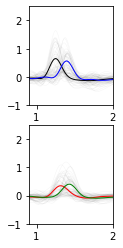

In [79]:
#plot responses for all rois in a cluster
fig, ax = plt.subplots(2, 1, figsize=(1.5, 4))

n_conds = cluster_frame['mu'].iloc[0].shape[0]
x_predict_t = cluster_frame['x_predict'].iloc[0][::n_conds,:]

average_out = np.zeros(x_predict_t[:,0].shape[0])
average_in = np.zeros(x_predict_t[:,0].shape[0])
average_out_drug = np.zeros(x_predict_t[:,0].shape[0])
average_in_drug = np.zeros(x_predict_t[:,0].shape[0])

for i in range(cluster_frame['mu'].shape[0]):
    out_motion = cluster_frame['mu'].iloc[i][4,:]
    average_out += out_motion
    in_motion = cluster_frame['mu'].iloc[i][0,:]
    average_in += in_motion
    
    out_motion_drug = cluster_frame['mu_drug'].iloc[i][4,:]
    average_out_drug += out_motion_drug
    in_motion_drug = cluster_frame['mu_drug'].iloc[i][0,:]
    average_in_drug += in_motion_drug
    
    ax[0].plot(x_predict_t[:,0], out_motion, c='grey', alpha=0.08, linewidth=0.5)
    ax[0].plot(x_predict_t[:,0], in_motion, c='grey', alpha=0.08, linewidth=0.5)

    
    ax[1].plot(x_predict_t[:,0], out_motion_drug, c='grey', alpha=0.08, linewidth=0.5)
    ax[1].plot(x_predict_t[:,0], in_motion_drug, c='grey', alpha=0.08, linewidth=0.5)


average_out/=(i+1)
average_in/=(i+1)
average_out_drug/=(i+1)
average_in_drug/=(i+1)

ax[0].plot(x_predict_t[:,0], average_out, c='k', linewidth=1)
ax[0].plot(x_predict_t[:,0], average_in, c='b', linewidth=1)
ax[0].set_ylim([-1,2.5])
ax[0].set_xlim([0.9,2.0])


ax[1].plot(x_predict_t[:,0], average_out_drug, c='r', linewidth=1)
ax[1].plot(x_predict_t[:,0], average_in_drug, c='g', linewidth=1)
ax[1].set_ylim([-1,2.5])
ax[1].set_xlim([0.9,2.0])


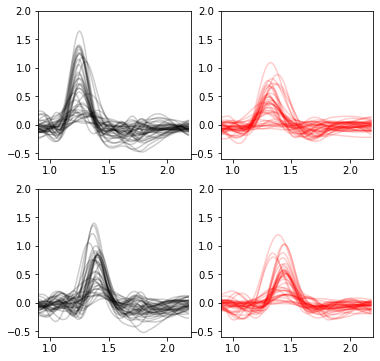

In [80]:
#plot responses (mu) for all rois in a cluster
fig, ax = plt.subplots(2, 2, figsize=(6, 6))

n_conds = cluster_frame['mu'].iloc[0].shape[0]
x_predict_t = cluster_frame['x_predict'].iloc[i][::n_conds,:]

for i in range(cluster_frame['mu'].shape[0]):
    out_motion = cluster_frame['mu'].iloc[i][4,:]
    in_motion = cluster_frame['mu'].iloc[i][0,:]
    
    out_motion_drug = cluster_frame['mu_drug'].iloc[i][4,:]
    in_motion_drug = cluster_frame['mu_drug'].iloc[i][0,:]
    
    ax[0,0].plot(x_predict_t[:,0], out_motion, c='k', alpha=0.2)
    ax[1,0].plot(x_predict_t[:,0], in_motion, c='k', alpha=0.2)
    ax[0,0].set_ylim([-0.6,2.0])
    ax[1,0].set_ylim([-0.6,2.0])
    ax[0,0].set_xlim([0.9,2.2])
    ax[1,0].set_xlim([0.9,2.2])
    
    ax[0,1].plot(x_predict_t[:,0], out_motion_drug, c='r', alpha=0.2)
    ax[1,1].plot(x_predict_t[:,0], in_motion_drug, c='r', alpha=0.2)
    ax[0,1].set_ylim([-0.6,2.0])
    ax[1,1].set_ylim([-0.6,2.0])
    ax[0,1].set_xlim([0.9,2.2])
    ax[1,1].set_xlim([0.9,2.2])

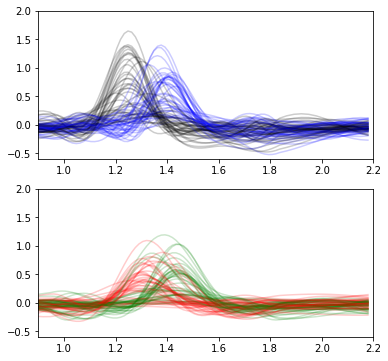

In [81]:
#plot responses for all rois in a cluster
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

n_conds = cluster_frame['mu'].iloc[0].shape[0]
x_predict_t = cluster_frame['x_predict'].iloc[i][::n_conds,:]

for i in range(cluster_frame['mu'].shape[0]):
    out_motion = cluster_frame['mu'].iloc[i][4,:]
    in_motion = cluster_frame['mu'].iloc[i][0,:]
    
    out_motion_drug = cluster_frame['mu_drug'].iloc[i][4,:]
    in_motion_drug = cluster_frame['mu_drug'].iloc[i][0,:]
    
    ax[0].plot(x_predict_t[:,0], out_motion, c='k', alpha=0.2)
    ax[0].plot(x_predict_t[:,0], in_motion, c='b', alpha=0.2)
    ax[0].set_ylim([-0.6,2.0])
    ax[0].set_xlim([0.9,2.2])
    
    ax[1].plot(x_predict_t[:,0], out_motion_drug, c='r', alpha=0.2)
    ax[1].plot(x_predict_t[:,0], in_motion_drug, c='g', alpha=0.2)
    ax[1].set_ylim([-0.6,2.0])
    ax[1].set_xlim([0.9,2.2])

In [82]:
cluster_frame[cluster_frame['dsi_100']<-10]

,d_prime,condition1,condition2,mu1,mu2,x_predict,mu,sig,x_predict_drug,mu_drug,...,dsi_150d,dsi_200d,dsi_300d,out_motion_d,in_motion_d,motion_origin_pref_d,cluster_assignment,cluster_center,field,dsi_diff
393,"[-10.958884185406854, -0.8555411010350612, 3.6...","[[0.0, 1.0, 100.0], [0.0, 1.0, 150.0], [0.0, 1...","[[1.2246467991473532e-16, -1.0, 100.0], [1.224...","[0.11778698562987536, 0.8266897290924624, 0.86...","[0.2606972260727663, 0.8378419618202562, 0.816...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.019197329011356838, -0.009721602597100053...","[[0.017811520579128194, 0.013633121176758987, ...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[0.02302639921184469, 0.02096523690143339, 0....",...,-5.443623,10.251614,3.252428,0.074423,0.033881,0.374339,9,8.0,44.0,-4.829090
397,"[-29.064544809319965, 20.577837661777146, 0.25...","[[0.0, 1.0, 100.0], [0.0, 1.0, 150.0], [0.0, 1...","[[1.2246467991473532e-16, -1.0, 100.0], [1.224...","[0.8774695154068302, 2.385182486979442, 2.0671...","[1.2671592767567743, 2.0187294705483843, 2.063...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[0.002466613918097057, -0.053980268757315285,...","[[0.02321287798967625, 0.015192783434903101, 0...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.03369446624162259, -0.05537290028869454, ...",...,22.673080,3.056076,-29.548513,0.654301,0.561185,0.076607,9,8.0,44.0,-22.684377
425,"[-34.07585979226183, 6.495037820961673, -4.953...","[[0.0, 1.0, 100.0], [0.0, 1.0, 150.0], [0.0, 1...","[[1.2246467991473532e-16, -1.0, 100.0], [1.224...","[0.8366710573704786, 2.242161738814428, 2.0687...","[1.3263568309674436, 2.149440183882677, 2.1395...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.12267014697171803, -0.1704755897432376, -...","[[0.02407432861924219, 0.015578020521759217, 0...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.056100220449786076, -0.07006836440536801,...",...,14.553552,12.316455,-27.044517,0.423439,0.562380,-0.140939,9,8.0,44.0,-43.858975
449,"[-21.034796403593397, 8.496086499092577, -2.11...","[[0.0, 1.0, 100.0], [0.0, 1.0, 150.0], [0.0, 1...","[[1.2246467991473532e-16, -1.0, 100.0], [1.224...","[0.806680586235273, 2.016076045701024, 1.75545...","[1.1475644800716422, 1.8930467771927912, 1.786...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.17017799784370707, -0.21463454409358973, ...","[[0.023211343554044472, 0.015448884993038814, ...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.008710025236704277, -0.02223515391372577,...",...,1.730239,5.877730,-11.731317,0.362506,0.453695,-0.111723,9,8.0,44.0,-27.939059
1150,"[-12.176423418916686, 1.1374897286605228, 2.50...","[[0.0, 1.0, 100.0], [0.0, 1.0, 150.0], [0.0, 1...","[[1.2246467991473532e-16, -1.0, 100.0], [1.224...","[1.210079261819494, 1.0870556053423464, 1.0459...","[1.3752496568417298, 1.071624397150702, 1.0119...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.0388341849804669, -0.014759354906036864, ...","[[0.021132731471800267, 0.01513785763233387, 0...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.05927419373186621, -0.03836109526893873, ...",...,5.902364,-10.242601,6.193216,0.518091,0.542453,-0.022970,9,10.0,44.0,-14.304286
1181,"[-28.767125472298012, -12.969370424073581, 5.8...","[[0.0, 1.0, 100.0], [0.0, 1.0, 150.0], [0.0, 1...","[[1.2246467991473532e-16, -1.0, 100.0], [1.224...","[0.839431728258155, 1.026398551163308, 1.32958...","[1.2525310652259096, 1.2122334983828789, 1.246...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.07222991208223205, -0.08492062026742755, ...","[[0.020523412677545302, 0.014799803446026771, ...","[[0.0, 0.0, 1.0, 100.0], [0.0, 0.0, 1.0, 300.0...","[[-0.05913776397646031, -0.03976680021131607, ...",...,0.482722,-0.801802,19.023721,0.773781,0.783446,-0.006207,9,10.0,44.0,-29.557496
1183,"[-15.625308427303027, -16.98354065023041, 17.4...","[[0.0, 1.0, 100.0], [0.0, 1.0, 150.0], [0.0, 1...","[[1.2246467991473532e-16, -1.0, 100.0],

In [83]:
def compute_bounds(mu, sig, n_sigma = 3):
    """
    Use mean and standard deviation vectors to compute upper and lower bounds.
    """
    upper = mu + n_sigma * np.sqrt(np.abs(sig))
    lower = mu - n_sigma * np.sqrt(np.abs(sig))
    
    return upper, lower

(0.9, 2.0)

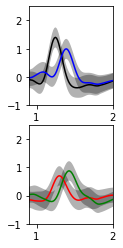

In [84]:
#plot a single roi
roi_num = 1207 #1207#1183#
out_motion = cluster_frame['mu'].loc[roi_num][4,:]
in_motion = cluster_frame['mu'].loc[roi_num][0,:]

out_motion_sig = cluster_frame['sig'].loc[roi_num][4,:]
in_motion_sig = cluster_frame['sig'].loc[roi_num][0,:]

out_motion_drug = cluster_frame['mu_drug'].loc[roi_num][4,:]
in_motion_drug = cluster_frame['mu_drug'].loc[roi_num][0,:]

out_motion_sig_drug = cluster_frame['sig_drug'].loc[roi_num][4,:]
in_motion_sig_drug = cluster_frame['sig_drug'].loc[roi_num][0,:]


fig, ax = plt.subplots(2, 1, figsize=(1.5, 4))

upper, lower = compute_bounds(out_motion, out_motion_sig, n_sigma = 3)
ax[0].fill_between(x_predict_t[:,0], upper, lower, facecolor = 'k', alpha = 0.3)
ax[0].plot(x_predict_t[:,0], out_motion, c='k')#

upper, lower = compute_bounds(in_motion, in_motion_sig, n_sigma = 3)
ax[0].fill_between(x_predict_t[:,0], upper, lower, facecolor = 'k', alpha = 0.3)
ax[0].plot(x_predict_t[:,0], in_motion, c='b')#, alpha=0.2)
ax[0].set_ylim([-1,2.5])
ax[0].set_xlim([0.9,2.0])

upper, lower = compute_bounds(out_motion_drug, out_motion_sig_drug, n_sigma = 3)
ax[1].fill_between(x_predict_t[:,0], upper, lower, facecolor = 'k', alpha = 0.3)
ax[1].plot(x_predict_t[:,0], out_motion_drug, c='r')#, alpha=0.2)

upper, lower = compute_bounds(in_motion_drug, in_motion_sig_drug, n_sigma = 3)
ax[1].fill_between(x_predict_t[:,0], upper, lower, facecolor = 'k', alpha = 0.3)
ax[1].plot(x_predict_t[:,0], in_motion_drug, c='g')#, alpha=0.2)
ax[1].set_ylim([-1,2.5])
ax[1].set_xlim([0.9,2.0])
